## Neural network design and calculated loss 

100%|██████████| 1000/1000 [22:13<00:00,  1.33s/it, Loss=0.0018420698]


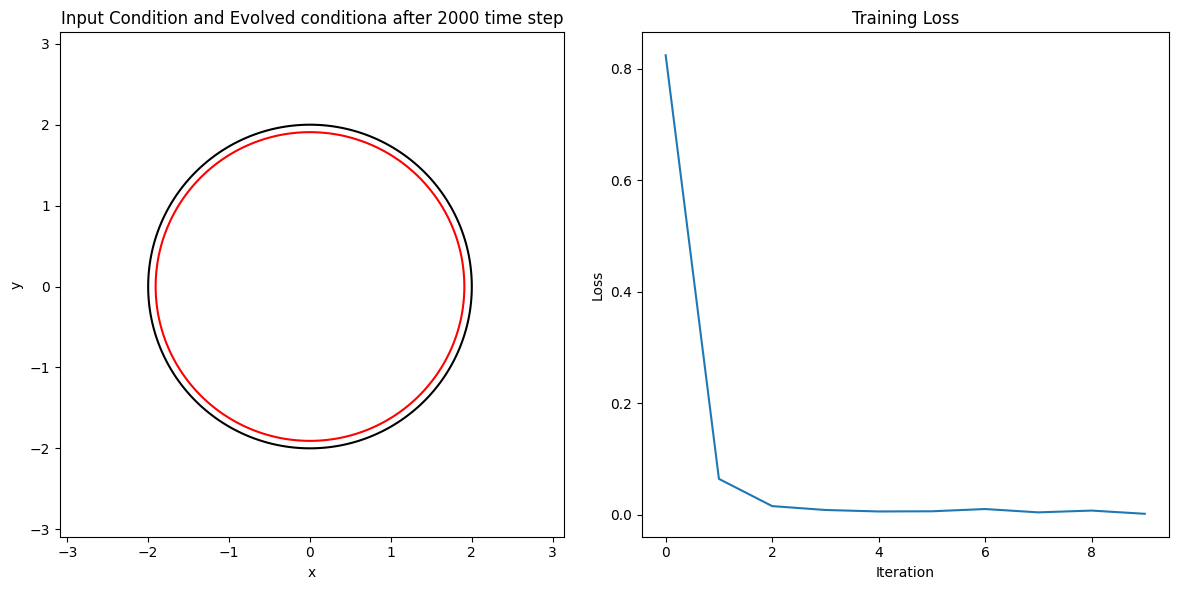

In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.example_libraries.stax import Dense, Gelu, serial
from jax.example_libraries.optimizers import optimizer, make_schedule
# from jax.scipy.fftpack import fftn, ifftn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from functools import partial
from jax.numpy.fft import fftn, ifftn, fftshift, ifftshift
from jax.example_libraries.optimizers import exponential_decay
import jax.numpy.fft as jfft
from jax.example_libraries.stax import Dense, Gelu, serial, glorot_normal
from spifol_archs import FNOBlock2D, Permute, complex_adam, MLP, modified_MLP




def fft2(x):
   """Applies a 2D FFT over the first two dimensions of the input array x."""
   return fftn(x, axes=(0, 1))


def ifft2(x):
   """Applies a 2D inverse FFT over the first two dimensions of the input array x."""
   return ifftn(x, axes=(0, 1))




# Define normalization and denormalization functions
def normalize(data):
   mean = jnp.mean(data)
   std = jnp.std(data)
   return (data - mean) / std, mean, std


def denormalize(data, mean, std):
   return data * std + mean



class SPiFOL:
   def __init__(self, L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers, mlp_layers,lr, arch):
       self.arch = arch
       self.N = N
       self.lr = lr
       # self.norm_par = norm_par
       self.eps = eps
       self.pp2 = pp2
       self.qq2 = qq2
       self.dt = dt
       self.L = L
       self.h = h
       self.x = x
       self.y = y
       # Initialize the network based on architecture type
       if arch == 'FNO':
           self.N_init, self.N_apply = serial(*fno_layers)
           _, params = self.N_init(random.PRNGKey(1234), (-1, N, N, 1))
          
       elif arch == 'MLP':
           self.N_init, self.N_apply = MLP(mlp_layers)
           params = self.N_init(random.PRNGKey(1234))
          
       elif arch == 'modified_MLP':
           self.N_init, self.N_apply = modified_MLP(mlp_layers)
           params = self.N_init(random.PRNGKey(1234))
       else:
           raise ValueError("Unsupported architecture!")


       self.params = params


    
       # Optimizer setup
       self.opt_init, self.opt_update, self.get_params = complex_adam(
           jax.example_libraries.optimizers.exponential_decay(
               lr, decay_steps=2000, decay_rate=0.9)
           )
      
       self.opt_state = self.opt_init(self.params)


       # Logging losses
       self.total_loss_log = []
       self.total_energy_loss_log = []


       # Initialize optimizer state
       self.opt_state = self.opt_init(self.params)
       self.itercount = iter(range(50000))


   @partial(jit, static_argnums=(0,))
   def operator_net(self, params, uk):
       if self.arch == 'FNO':
           uk = uk.reshape(-1, self.N, self.N, 1)  # Reshape input 
           O = self.N_apply(params, uk)  # Apply the FNO network
           O = jnp.real(O)  # Take the real part of the output
           O = O.reshape(self.N, self.N)  # Reshape output
           return O
       elif self.arch == 'MLP':
           uk = uk.flatten()
           O = self.N_apply(params, uk)  # Directly apply the network
           O = O.reshape(self.N, self.N)  # Reshape output to match strain components
           # O = O / self.norm_par  # Normalize the output
           return O
       elif self.arch == 'modified_MLP':
           uk = uk.flatten()
           O = self.N_apply(params, uk)
           O = O.reshape(self.N, self.N)
           return O
       else:
           raise ValueError("Unsupported architecture type!")
      

   def allen_cahn_equation(self, uk, total_steps=2000):
        for _ in range(total_steps):
            cahn = eps**2
            uk = jnp.real(uk)
            # Allen-Cahn equation in Fourier space
            s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk))
            v_hat = s_hat / (cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2)))
            uk = jfft.ifft2(v_hat)  # Update uk to the next state
        # uk = np.load('final_output.npy_20000.npy')
            # print(f'shree is my heart')

        return jnp.real(uk)  # Return only the final state
   

   @partial(jit, static_argnums=(0,))
   def loss_single(self, params, uk):
        u_nn = self.operator_net(params, uk) # predicted or next value of the initial condition
        u_nn = u_nn.reshape(self.N, self.N)
        u_ac = self.allen_cahn_equation(uk)
        
        # Allen-Cahn equation loss
    #    energy_loss = self.total_energy(u_pred)
        datadriven_loss = jnp.mean((u_ac - u_nn) ** 2)
    #    total_loss = distance_loss + energy_loss
        return datadriven_loss
   

   @partial(jit, static_argnums=(0,))
   def step(self, i, opt_state, uk):
        params = self.get_params(opt_state)
        grads = grad(self.loss_single)(params, uk)
        return self.opt_update(i, grads, opt_state)


   def train(self, uk, nIter=1000):
        pbar = trange(nIter)
        for it in pbar:
            self.opt_state = self.step(next(self.itercount), self.opt_state, uk)
    #    self.itercount = iter(range(nIter))  # Create an iterator
            



            # Logger (log the loss every 100 iterations)
            if it % 100 == 0:
                params = self.get_params(self.opt_state)
                loss = self.loss_single(params, uk)
                self.total_loss_log.append(loss)
                # self.total_energy_loss_log.append(energy_loss)
                pbar.set_postfix({'Loss': loss})


# Parameters
N = 128 # no. of grid points
eps = 0.05 # epsillon 
lr = 0.1 # learning rate
dt = 0.0001 # time step or time increment
L = 2 * jnp.pi # length of domian
h = L/N # spacing between grid or length of grid





x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)


theta = jnp.arctan2(y, x)
# Generate input condition
xx, yy = jnp.meshgrid(x, y)
input_condition = jnp.tanh((2 - jnp.sqrt(xx**2 + yy**2)) / jnp.sqrt(2)* eps)

 # defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2 , 0)])




# # square of wavenumber in x and y direction
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction


# # creating meshgrid in x and y direction for square of wavenumber
pp2, qq2 = jnp.meshgrid(p2, q2)


# arch_list = ['FNO', 'MLP', 'modified_MLP']
arch_list = ['FNO']
# arch = 'modified_MLP'
# mlp layers
mlp_layers = [16384, 32, 32, 16384]


# Define FNO layers
fno_layers = [
   Dense(32),
#    Permute("ijkl->iljk"),
#    FNOBlock2D(32),
   Gelu,  # activation can be changed here
#    FNOBlock2D(32),
#    Gelu,
#    FNOBlock2D(32),
#    Permute("ijkl->iklj"),
   Dense(32),
   Gelu,
   Dense(1),
]



cahn = eps**2
for arch in arch_list:
   # Initialize and train the model
    model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers,mlp_layers,lr, arch)
    # final_state = model.allen_cahn_equation(input_condition)
    model.train(input_condition, nIter=1000)


params = model.get_params(model.opt_state)
model_prediction = model.operator_net(params, input_condition).reshape(N, N)



# Plot the initial and final states
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Input condition plot
axs[0].contour(x, y, jnp.real(input_condition.T), levels=[0], colors="black")
axs[0].contour(x, y, jnp.real(model_prediction.T), levels=[0], colors="red")

axs[0].set_title('Input Condition and Evolved conditiona after 2000 time step')
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')


# #    # Plot loss
axs[1].plot(model.total_loss_log)
axs[1].set_title('Training Loss')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Loss')






plt.tight_layout()
plt.show()

            

## Data generation 

## Data save (train_data and test data)


Training data shape (u_train): (1, 128, 128, 3)
Testing data shape (u_test): (1, 128, 128, 3)
Saving training data to u_train.npy...
Saving testing data to u_test.npy...
Saving grid points to grid.npy...
Time to save the data: 0.02 seconds
Data saving completed!


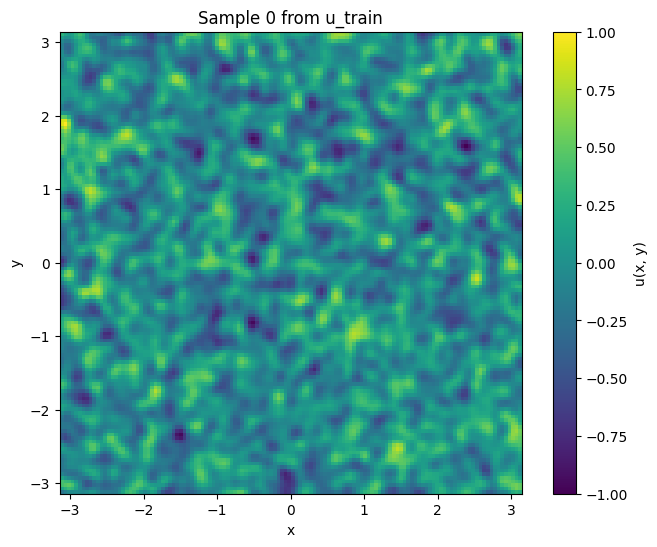

In [1]:
import jax.numpy as jnp
import numpy as np
from jax import random
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import os
import time





# Exponential quadratic kernel (Gaussian kernel)
def exp_quadratic(X1, X2, length_scale):
    """Compute the exponential quadratic kernel."""
    dists = cdist(X1, X2, metric="sqeuclidean") #dists is distance and cdists is computed distance between two points 
    # print("Distances min:", jnp.min(dists), "max:", jnp.max(dists))
    kernel = jnp.exp(-dists / (2 * length_scale**2))
    # print("Kernel min:", jnp.min(kernel), "max:", jnp.max(kernel))
    return kernel


# Gaussian process data generator
def gaussian_process_2d(x, n_grid, n_samples, length_scale_list, u_mean=0.0, key=None):
    """
    Generate 2D Gaussian process samples.
    
    Args:
        x: Tuple of domain limits [x1, x2, y1, y2].
        n_grid: Number of grid points in each dimension.
        n_samples: Number of samples to generate.
        length_scale_list: List of length scales for kernel.
        u_mean: Mean value for Gaussian process.
        key: PRNGKey for randomization.

    Returns:
        X: Grid points.
        ys: Samples generated from the Gaussian process.
    """
    x1, x2, y1, y2 = x
    # Create grid
    xx, yy = jnp.meshgrid(
        jnp.linspace(x1, x2, n_grid), jnp.linspace(y1, y2, n_grid)
    )
    grid_points = jnp.stack([xx.ravel(), yy.ravel()], axis=-1)

    if key is None:
        key = random.PRNGKey(42)

    samples = []
    for _ in range(n_samples):
        # print(f'for sample {i+1}')
        # Select random length scale
        length_scale = random.choice(key, jnp.array(length_scale_list))
        # Compute covariance matrix
        cov = exp_quadratic(grid_points, grid_points, length_scale)
        jitter = 1e-5
        cov += jitter * jnp.eye(cov.shape[0])

        # print("Covariance matrix shape:", cov.shape)
        # eigenvalues = jnp.linalg.eigvalsh(cov)
        # # print("After adding jitter:")
        # print("Covariance matrix eigenvalues min:", jnp.min(eigenvalues), "max:", jnp.max(eigenvalues))

        # Generate sample
        sample = random.multivariate_normal(key, u_mean * jnp.ones(grid_points.shape[0]), cov)
        samples.append(sample)

    return grid_points, jnp.array(samples)


# # Normalize function
# def normalize(data):
#     """Normalize data to the range [-1, 1]."""
#     return 2 * (data - jnp.min(data)) / (jnp.max(data) - jnp.min(data)) - 1


def normalize(data):
    """Normalize data to the range [-1, 1]."""
    min_val = jnp.min(data)
    max_val = jnp.max(data)
    if max_val - min_val == 0:
        return data  # Return unchanged if normalization isn't possible
    return 2 * (data - min_val) / (max_val - min_val) - 1


# Data class
class Data:
    def __init__(self, x, n_grid, length_scale_list, train_num, test_num):
        """
        Initialize data generator.

        Args:
            x: Tuple of domain limits [x1, x2, y1, y2].
            n_grid: Resolution of the grid (number of grid points per dimension).
            length_scale_list: List of length scales for the Gaussian process.
            train_num: Number of training samples to generate.
            test_num: Number of testing samples to generate.
        """
        self.x = x
        self.n_grid = n_grid
        self.length_scale_list = length_scale_list
        self.train_num = train_num
        self.test_num = test_num
        self.__init_data()

    def __init_data(self):
        """Initialize training and testing data."""
        self.X, self.u_train = self.u_data(self.train_num)
        _, self.u_test = self.u_data(self.test_num)

    def u_data(self, n_samples=1):
        """
        Generate Gaussian process data.

        Args:
            n_samples: Number of samples to generate.

        Returns:
            X: Grid points.
            us: Corresponding u(x) values at the grid points.
            us: Corresponding u(x) values at the grid points with 3 channels (RGB).
        """
        # Generate data using Gaussian process
        X, us = gaussian_process_2d(
            self.x, self.n_grid, n_samples, self.length_scale_list
        )

        # Normalize and reshape the samples
        us = normalize(us)
        us = us.reshape(-1, self.n_grid, self.n_grid, 1)

        # print(f"Generated {n_samples} samples with shape: {us.shape}")


        # Now create RGB data for each sample, using np.random.rand for each channel
        # Here we create random RGB values for each sample (you can adjust this as needed)
        us_rgb = np.random.rand(n_samples, self.n_grid, self.n_grid, 3)  # RGB values for color images

        # You could also modify the us data to contain meaningful RGB values
        # Example: combining some part of 'us' for each channel
        us_rgb[..., 0] = us[..., 0]  # Red channel from the 'us' data
        us_rgb[..., 1] = us[..., 0]  # Green channel from the 'us' data
        us_rgb[..., 2] = us[..., 0]  # Blue channel from the 'us' data

        return X, us_rgb

        # return X, us


# Example Usage
if __name__ == "__main__":
    # Example: Adjust resolution and domain length
    domain = (-jnp.pi, jnp.pi, -jnp.pi, jnp.pi)  
    resolution = 128  # Number of grid points per dimension
    length_scale_list = [0.1, 0.5, 1.0, 2.0]  # Kernel length scales # its indicate the smoothness of the data 
    train_samples = 1 # Number of training samples
    test_samples = 1  # Number of testing samples

    # Create data object
    data = Data(domain, resolution, length_scale_list, train_samples, test_samples)

    # Specify the directory where y want to save the data
    save_dir = './data_generation/'

     # Ensure the directory exists, create it if not
    os.makedirs(save_dir, exist_ok=True)

    # Access generated data
    print("Training data shape (u_train):", data.u_train.shape)  # (train_samples, resolution, resolution, 1)
    print("Testing data shape (u_test):", data.u_test.shape)  # (test_samples, resolution, resolution, 1)

    # Start the timer
    start_time = time.time()

    # Save the training and testing data
    print("Saving training data to u_train.npy...")
    np.save(os.path.join(save_dir, "u_train.npy"), np.array(data.u_train))

    print("Saving testing data to u_test.npy...")
    np.save(os.path.join(save_dir, "u_test.npy"), np.array(data.u_test))

    # print("Data saving completed!")

    # # Save the grid points (optional, if you want to reconstruct spatial locations)
    print("Saving grid points to grid.npy...")
    np.save("grid.npy", np.array(data.X))  # Assuming 'data.X' contains the grid points

    # Calculate the elapsed time
    elapsed_time = time.time() - start_time
    print(f"Time to save the data: {elapsed_time:.2f} seconds")

    print("Data saving completed!")




    # # Specify the directory where you want to save the data
    # save_dir = './data_generation/'

    # # Ensure the directory exists, create it if not
    # os.makedirs(save_dir, exist_ok=True)

    # # Save the data with the full path to the specific folder
    # np.save(os.path.join(save_dir, "u_train_dg.npy"), np.array(data.u_train))
    # np.save(os.path.join(save_dir, "u_test_dg.npy"), np.array(data.u_test))



# # Save the training and testing data
# np.save("u_train_dg.npy", np.array(data.u_train))
# np.save("u_test_dg.npy", np.array(data.u_test))

# # # Save the grid points (optional, if you want to reconstruct spatial locations)
# np.save("grid.npy", np.array(data.X))  # Assuming 'data.X' contains the grid points


# Select a sample to plot
sample_index = 0  # Choose a specific sample (e.g., the first one)
sample = data.u_train[sample_index, :, :, 0]  # Extract the 2D array for the sample
# print(f'sample data = {sample}')

# Plot the sample
plt.figure(figsize=(8, 6))
plt.imshow(sample, extent=[-jnp.pi, jnp.pi, -jnp.pi, jnp.pi], origin='lower', cmap='viridis')
plt.colorbar(label="u(x, y)")
plt.title(f"Sample {sample_index} from u_train")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


## This is for single sample

Sample min: -1.0
Sample max: 1.0
Sample mean: -0.023240553215146065
Number of NaN values: 0


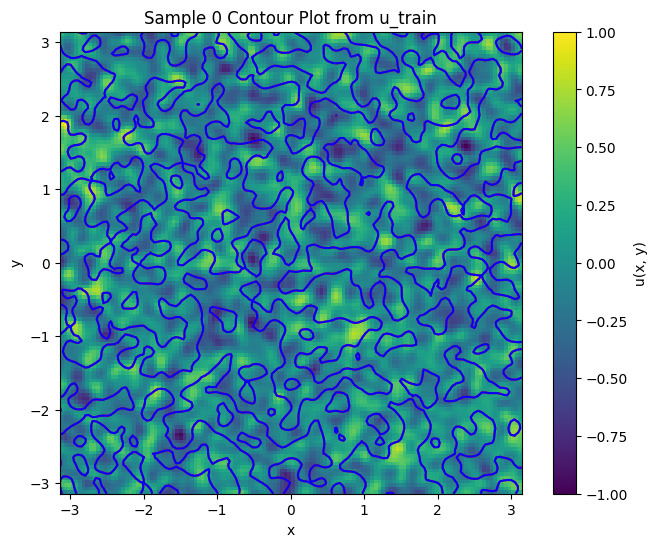

In [16]:
print(f"Sample min: {np.min(sample)}")
print(f"Sample max: {np.max(sample)}")
print(f"Sample mean: {np.mean(sample)}")

print(f"Number of NaN values: {np.sum(np.isnan(sample))}")


# for i in range(5):
#     sample = data.u_train[i, :, :, 0]  # Check first 5 samples
#     plt.imshow(sample, extent=[-jnp.pi, jnp.pi, -jnp.pi, jnp.pi], origin='lower', cmap='viridis')
#     plt.title(f"Sample {i}")
#     plt.colorbar(label="u(x, y)")
#     plt.show()






# # Plot the sample using contour plot
# plt.figure(figsize=(8, 6))
# # Contour plot
# plt.contourf(sample, levels=50, cmap='viridis', extent=[-jnp.pi, jnp.pi, -jnp.pi, jnp.pi])
# plt.colorbar(label="u(x, y)")
# plt.title(f"Sample {sample_index} from u_train")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.show()

# Ensure sample_index is within bounds
sample_index = 0  # Choose the sample index (e.g., the first one)
if sample_index >= data.u_train.shape[0]:
    raise IndexError(f"sample_index {sample_index} is out of bounds for u_train with shape {data.u_train.shape}")

# Extract the sample (2D array)
sample = data.u_train[sample_index, :, :, 0]  # This extracts the 2D array of shape (128, 128)
sample_1 = data.u_train[sample_index, :, :, 1]  # This extracts the 2D array of shape (128, 128)

# Create the grid points (xx, yy)
x1, x2, y1, y2 = data.x  # domain limits
xx, yy = jnp.meshgrid(
    jnp.linspace(x1, x2, data.n_grid), jnp.linspace(y1, y2, data.n_grid)
)

# Plot using contour
plt.figure(figsize=(8, 6))
contour = plt.contour(xx, yy, jnp.real(sample.T), [0], colors='red')  # Contour at level 0 (can change levels)
contour = plt.contour(xx, yy, jnp.real(sample_1.T), [0], colors='blue')  # Contour at level 0 (can change levels)

plt.imshow(sample, extent=[-jnp.pi, jnp.pi, -jnp.pi, jnp.pi], origin='lower', cmap='viridis')

plt.colorbar(label="u(x, y)")  # Add color bar for better understanding
plt.title(f"Sample {sample_index} Contour Plot from u_train")
plt.title(f"Sample {sample_index} Contour Plot from u_train")
plt.xlabel("x")
plt.ylabel("y")
plt.show()



## Given sample_1 input on Allen cahn and check its work or not

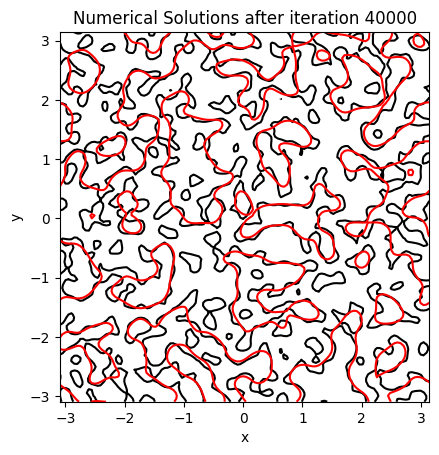

In [26]:
import jax
import numpy as np
import jax.random as random
import jax.numpy as jnp
import jax.numpy.fft as jfft
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from numpy import sqrt
from numpy import round
from matplotlib import pyplot as plt
from matplotlib import contour
from jax.numpy.fft import fft2, ifft2
from jax.numpy.fft import fftn, ifftn
from numpy import real
from jax.example_libraries.stax import serial, Gelu
from jax.example_libraries.optimizers import optimizer, make_schedule
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter






# difinning the no of grid points in x, y and z
Nx = 128 # number of grid points in x be positive even integer number
Ny = 128 # number of grid points in y be positive even integer number
Nz = 128 # number of grid points in z be positive even integer number



# Define the parameters of the Allen-Cahn equation in 2d
Lx = 2.0 * jnp.pi #length of the domain in x
Ly = 2.0 * jnp.pi #length of the domain in y
hx = Lx / Nx #spatial step size in coordinate x
hy = Ly / Ny #spatial step size in coordinate y
dt = 0.0001 #time step size
T = 4 #final time
Nt = int(jnp.round(T/dt)) #number of time steps
ns = Nt / 10 #number of snapshots

# Define the grid points in x and y direction
def x_gridpoint(Nx, Lx, hx):
    x = jnp.linspace(-0.5*Lx+hx,0.5*Lx,Nx)
    return x
x = x_gridpoint(Nx, Lx, hx) #number of grid points in x direction and step size and limitation on x  axis
def y_gridpoint(Ny, Ly, hy):
    y = jnp.linspace(-0.5*Ly+hy,0.5*Ly,Ny)
    return y
y = y_gridpoint(Ny, Ly, hy) #number of grid points in y direction and step size and limitation on y  axis 

# creating meshgrid in x and y direction
xx,yy = jnp.meshgrid(x,y) #creating meshgrid in x and y direction 

# defining parameters for the Allen-Cahn equation
#It determines the scale of the transition region (interface width) between phases. its the width of the interface, smaller epsillon refer to the sharp transition

epsillon = 0.05 #small parameter # interface thickness in the Allen-Cahn equation 
cahn = epsillon**2 #cahn number  

# initial condition of allen cahn equation
# uk =jnp.tanh((2 -sqrt(xx**2 + yy**2)) / (sqrt(2) *epsillon)) #initial condition of allen cahn equation
# theta = jnp.arctan(y/x)
# u =jnp.tanh((1.7 - 1.2 * jnp.cos(6*theta) - sqrt(xx**2 + yy**2)) / (sqrt(2) *epsillon))
uk = sample_1

# defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / Lx * jnp.arange(0, Nx//2), 2 * jnp.pi / Lx * jnp.arange(-Nx//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / Ly * jnp.arange(0, Ny//2), 2 * jnp.pi / Ly * jnp.arange(-Ny//2 , 0)])


# square of wavenumber in x and y direction
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction

# creating meshgrid in x and y direction for square of wavenumber
pp2, qq2 = jnp.meshgrid(p2, q2)
#print(pp2.shape) # creating meshgrid in x and y direction for square of wavenumber


# # plotting the initial condition of the Allen-Cahn equation


#this figure code is pervious code 
figure1 = plt.figure()
plt.contour(x, y, jnp.real(uk.T), [0], colors = 'black')
plt.gca().set_aspect('equal', adjustable='box') 
plt.title('Initial condition')
plt.xlabel('x')
plt.ylabel('y')
# plt.show()


# # providing the range of iteration

for iter in range(1, Nt):
    u = jnp.real(uk)
    # print(f'real space u ko size ={u.shape}')
    # Transforming the solution to the discrete Fourier space
    s_hat = jfft.fft2(cahn * u - dt * (u**3 - 3 * u)) # us is the real space
    # print(f's_hat ko size = {s_hat.shape}')
    v_hat = s_hat / (cahn + dt * (2 + cahn * (pp2 + qq2)))  # Allen-Cahn equation
    uk = jfft.ifft2(v_hat)  # u_k+1 result
    # print(f'inverse u ko size = {u.shape}')



    if iter == 100:
        plt.contour(x, y, jnp.real(uk.T), [0], colors='red')
        plt.gca().set_aspect('equal', adjustable='box')
        
    # if iter == 4000:
    #     plt.contour(x, y, jnp.real(uk.T), [0], colors='green')
    #     plt.gca().set_aspect('equal', adjustable='box')
    
    # if iter == 10000:
    #     plt.contour(x, y, jnp.real(uk.T), [0], colors='blue')
    #     plt.gca().set_aspect('equal', adjustable='box')

    # if iter == 20000:
    #     plt.contour(x, y, jnp.real(uk.T), [0], colors='pink')
    #     plt.gca().set_aspect('equal', adjustable='box')


plt.title('Numerical Solutions after iteration ' + str(Nt))
plt.show()



## Training of 2000 data (1500 training and 500 test)

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.example_libraries.stax import Dense, Gelu, serial
from jax.example_libraries.optimizers import optimizer, make_schedule
# from jax.scipy.fftpack import fftn, ifftn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from functools import partial
from jax.numpy.fft import fftn, ifftn, fftshift, ifftshift
from jax.example_libraries.optimizers import exponential_decay
import jax.numpy.fft as jfft
from jax.example_libraries.stax import Dense, Gelu, serial, glorot_normal
from spifol_archs import FNOBlock2D, Permute, complex_adam, MLP, modified_MLP




def fft2(x):
   """Applies a 2D FFT over the first two dimensions of the input array x."""
   return fftn(x, axes=(0, 1))


def ifft2(x):
   """Applies a 2D inverse FFT over the first two dimensions of the input array x."""
   return ifftn(x, axes=(0, 1))




# Define normalization and denormalization functions
def normalize(data):
   mean = jnp.mean(data)
   std = jnp.std(data)
   return (data - mean) / std, mean, std


def denormalize(data, mean, std):
   return data * std + mean



class SPiFOL:
   def __init__(self, L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers, mlp_layers,lr, arch):
       self.arch = arch
       self.N = N
       self.lr = lr
       # self.norm_par = norm_par
       self.eps = eps
       self.pp2 = pp2
       self.qq2 = qq2
       self.dt = dt
       self.L = L
       self.h = h
       self.x = x
       self.y = y
       # Initialize the network based on architecture type
       if arch == 'FNO':
           self.N_init, self.N_apply = serial(*fno_layers)
           _, params = self.N_init(random.PRNGKey(1234), (-1, N, N, 1))
          
       elif arch == 'MLP':
           self.N_init, self.N_apply = MLP(mlp_layers)
           params = self.N_init(random.PRNGKey(1234))
          
       elif arch == 'modified_MLP':
           self.N_init, self.N_apply = modified_MLP(mlp_layers)
           params = self.N_init(random.PRNGKey(1234))
       else:
           raise ValueError("Unsupported architecture!")


       self.params = params


    
       # Optimizer setup
       self.opt_init, self.opt_update, self.get_params = complex_adam(
           jax.example_libraries.optimizers.exponential_decay(
               lr, decay_steps=2000, decay_rate=0.9)
           )
      
       self.opt_state = self.opt_init(self.params)


       # Logging losses
       self.total_loss_log = []
       self.total_energy_loss_log = []


       # Initialize optimizer state
       self.opt_state = self.opt_init(self.params)
       self.itercount = iter(range(50000))


   @partial(jit, static_argnums=(0,))
   def operator_net(self, params, uk):
       if self.arch == 'FNO':
           uk = uk.reshape(-1, self.N, self.N, 1)  # Reshape input 
           O = self.N_apply(params, uk)  # Apply the FNO network
           O = jnp.real(O)  # Take the real part of the output
           O = O.reshape(-1,self.N, self.N)  # Reshape output
           return O
       elif self.arch == 'MLP':
           uk = uk.flatten()
           O = self.N_apply(params, uk)  # Directly apply the network
           O = O.reshape(self.N, self.N)  # Reshape output to match strain components
           # O = O / self.norm_par  # Normalize the output
           return O
       elif self.arch == 'modified_MLP':
           uk = uk.flatten()
           O = self.N_apply(params, uk)
           O = O.reshape(self.N, self.N)
           return O
       else:
           raise ValueError("Unsupported architecture type!")
      

   def allen_cahn_equation(self, uk, total_steps=2000):
        for _ in range(total_steps):
#             # cahn = eps**2
#             # uk = jnp.real(uk)

#             # # Expand self.pp2 and self.qq2 to support broadcasting
#             # self.pp2 = self.pp2[jnp.newaxis, ...]  # Shape: (1, 128, 128)
#             # self.qq2 = self.qq2[jnp.newaxis, ...]  # Shape: (1, 128, 128)
#             # # Allen-Cahn equation in Fourier space
#             # # s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk))
#             # # Allen-Cahn equation in Fourier space
#             # s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk))  # Broadcasting works here

#             # print("uk shape before anything:", uk.shape)
#             # print("self.pp2 shape before anything:", self.pp2.shape)
#             # print("self.qq2 shape before anything:", self.qq2.shape)
#             # print("cahn value:", cahn)


#             # # Compute denominator and ensure it matches uk's shape
#             # denominator = cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2))  # Shape: (1, 128, 128)
#             # denominator = jnp.broadcast_to(denominator, uk.shape)  # Match shape with uk

#             # # Compute v_hat and transform back
#         #     v_hat = s_hat / denominator  # Broadcasting works here
#         #     uk = jfft.ifft2(v_hat)
        
#         #     # v_hat = s_hat / (cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2)))
#         #     # uk = jfft.ifft2(v_hat)  # Update uk to the next state
#         # # uk = np.load('final_output.npy_20000.npy')
#         #     # print(f'shree is my heart')

#             # print("uk shape:", uk.shape)
#         #     print("self.pp2 shape:", self.pp2.shape)
#         #     print("self.qq2 shape:", self.qq2.shape)
#         #     print("denominator shape before broadcast:", (cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2))).shape)

#         #     print(cahn.shape, uk.shape, self.pp2.shape, self.qq2.shape)

            cahn = eps**2
            uk = jnp.real(uk)
            # uk = jnp.complex64(uk)

            # Ensure shapes match for broadcasting
            self.pp2 = self.pp2[..., jnp.newaxis]  # Shape: (128, 128, 1) --> (128, 128, 1, 1)
            self.qq2 = self.qq2[..., jnp.newaxis]  # Shape: (128, 128, 1) --> (128, 128, 1, 1)

            
            # Check the shapes of pp2 and qq2
            print(f"pp2 shape after reshaping: {self.pp2.shape}")  # Expected: (1, 128, 128, 1)
            print(f"qq2 shape after reshaping: {self.qq2.shape}")  # Expected: (1, 128, 128, 1)

            # Check uk shape before broadcasting
            print(f"uk shape before broadcasting: {uk.shape}")  # Expected: (20, 128, 128, 3)

            # Allen-Cahn equation in Fourier space
            denominator = cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2))  # Shape should be (1, 128, 128, 1)
            # denominator = denominator[..., jnp.newaxis]  # Ensure it's (1, 128, 128, 1)
            print(f"denominator shape before broadcasting: {denominator.shape}")  # Expected: (1, 128, 128, 1)

           # Broadcast denominator to uk's shape
            denominator = jnp.broadcast_to(denominator, uk.shape)  # Shape: (20, 128, 128, 3)
            print(f"denominator shape after broadcasting: {denominator.shape}")  # Expected: (20, 128, 128, 3)
            

            
            s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk))  # Shape: (20, 128, 128, 3)
            v_hat = s_hat / denominator  # Broadcasting works here
            uk = jfft.ifft2(v_hat)  # Shape: (20, 128, 128, 3)
            
            # Check if everything else is correct
            print(f"s_hat shape after broadcasting: {s_hat.shape}")  # Expected: (20, 128, 128, 3)
            print(f"v_hat shape after broadcasting: {v_hat.shape}")  # Expected: (20, 128, 128, 3)
            print(f"uk shape after computation: {uk.shape}")  # Expected: (20, 128, 128, 3)



        return jnp.real(uk)  # Return only the final state
   
   


#    @jax.jit
#    def allen_cahn_equation(self, uk, total_steps=2000):
        
         


#        # Reshape pp2 and qq2 once before the loop
#         pp2 = self.pp2[..., jnp.newaxis]  # Shape: (128, 128, 1)
#         qq2 = self.qq2[..., jnp.newaxis]  # Shape: (128, 128, 1)
        
#         for step in range(total_steps):
#             cahn = eps**2
#             uk = jnp.real(uk)
#             print(f'[{step}] uk before broadcasting: {uk.shape}')


#            # Print the shape of pp2 and qq2 before broadcasting
#             print(f'[{step}] pp2 before broadcast: {pp2.shape}')
#             print(f'[{step}] qq2 before broadcast: {qq2.shape}')

#            # If pp2 and qq2 are of shape (128, 128), broadcast them to (128, 128, 3) for alignment with uk
#             # self.pp2 = jnp.broadcast_to(self.pp2[..., jnp.newaxis], (self.pp2.shape[0], self.pp2.shape[1], uk.shape[3]))
#             # self.qq2 = jnp.broadcast_to(self.qq2[..., jnp.newaxis], (self.qq2.shape[0], self.qq2.shape[1], uk.shape[3]))

#             #  Broadcast pp2 and qq2 to match uk.shape[3]
#             pp2_broadcasted = jnp.broadcast_to(pp2, (pp2.shape[0], pp2.shape[1], uk.shape[3]))  # (128, 128, 3)
#             qq2_broadcasted = jnp.broadcast_to(qq2, (qq2.shape[0], qq2.shape[1], uk.shape[3]))  # (128, 128, 3)

        #    # Print the shape of pp2 and qq2 after broadcasting
        #     print(f'[{step}] pp2 after broadcast: {pp2_broadcasted.shape}')
        #     print(f'[{step}] qq2 after broadcast: {qq2_broadcasted.shape}')

        #     # Compute denominator
        #     denominator = cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2))  # Shape: (128, 128, 3)
        #     print(f'[{step}] denominator before broadcasting: {denominator.shape}')
            
        #     # # Broadcast denominator to match uk shape (20, 128, 128, 3)
        #     denominator = jnp.broadcast_to(denominator, uk.shape)  # Broadcast to (128, 128, 3)
        #     print(f'[{step}] denominator after broadcasting: {denominator.shape}')
            
        #     # Perform Fourier calculations
        #     s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk))
        #     v_hat = s_hat / denominator  # Element-wise division

        #     # Inverse FFT
        #     uk = jfft.ifft2(v_hat)
        #     print(f'[{step}] s_hat after broadcasting: {s_hat.shape}')
        #     print(f'[{step}] v_hat after broadcasting: {v_hat.shape}')
        #     print(f'[{step}] uk after broadcasting: {uk.shape}')
        # return jnp.real(uk)  # Return the real part



   @partial(jit, static_argnums=(0,))
   def loss_single(self, params, uk):
        u_nn = self.operator_net(params, uk) # predicted or next value of the initial condition
        u_nn = u_nn.reshape(-1, self.N, self.N)
        print(f'[uk ko shape : {uk.shape}')

        u_ac = self.allen_cahn_equation(uk)
        
        # Allen-Cahn equation loss
    #    energy_loss = self.total_energy(u_pred)
        datadriven_loss = jnp.mean((u_ac - u_nn) ** 2)
    #    total_loss = distance_loss + energy_loss
        return datadriven_loss
   

   @partial(jit, static_argnums=(0,))
   def step(self, i, opt_state, uk):
        params = self.get_params(opt_state)
        grads = grad(self.loss_single)(params, uk)
        return self.opt_update(i, grads, opt_state)


   def train(self, uk, nIter=1000):
        pbar = trange(nIter)
        for it in pbar:
            self.opt_state = self.step(next(self.itercount), self.opt_state, uk)
    #    self.itercount = iter(range(nIter))  # Create an iterator
            



            # Logger (log the loss every 100 iterations)
            if it % 100 == 0:
                params = self.get_params(self.opt_state)
                loss = self.loss_single(params, uk)
                self.total_loss_log.append(loss)
                # self.total_energy_loss_log.append(energy_loss)
                pbar.set_postfix({'Loss': loss})


# Parameters
N = 128 # no. of grid points
eps = 0.05 # epsillon 
lr = 0.1 # learning rate
dt = 0.0001 # time step or time increment
L = 2 * jnp.pi # length of domian
h = L/N # spacing between grid or length of grid





x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)


theta = jnp.arctan2(y, x)
# Generate input condition
xx, yy = jnp.meshgrid(x, y)
# input_condition = jnp.tanh((2 - jnp.sqrt(xx**2 + yy**2)) / jnp.sqrt(2)* eps)
# input_condition = np.load (os.path.join(save_dir, "u_train.npy"), np.array(data.u_train))
# Load the .npy file
input_condition = np.load('data_generation/u_test.npy')
input_condition = input_condition[:1]

# Inspect the data
# print(input_condition)
# print(type(input_condition))


 # defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2 , 0)])




# # square of wavenumber in x and y direction
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction


# # creating meshgrid in x and y direction for square of wavenumber
pp2, qq2 = jnp.meshgrid(p2, q2)



# arch_list = ['FNO', 'MLP', 'modified_MLP']
arch_list = ['FNO']
# arch = 'modified_MLP'
# mlp layers
mlp_layers = [16384, 32, 32, 16384]


# Define FNO layers
fno_layers = [
   Dense(32),
#    Permute("ijkl->iljk"),
#    FNOBlock2D(32),
   Gelu,  # activation can be changed here
#    FNOBlock2D(32),
#    Gelu,
#    FNOBlock2D(32),
#    Permute("ijkl->iklj"),
   Dense(32),
   Gelu,
   Dense(1),
]



cahn = eps**2
for arch in arch_list:
   # Initialize and train the model
    model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers,mlp_layers,lr, arch)
    final_state = model.allen_cahn_equation(input_condition)
    # model.train(input_condition, nIter=1000)


# params = model.get_params(model.opt_state)
# model_prediction = model.operator_net(params, input_condition).reshape(N, N)



# Plot the initial and final states
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Input condition plot
axs[0].contour(x, y, jnp.real(input_condition.T), levels=[0], colors="black")
axs[0].contour(x, y, jnp.real(final_state.T), levels=[0], colors="red")

axs[0].set_title('Input Condition and Evolved conditiona after 2000 time step')
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')


# #    # Plot loss
axs[1].plot(model.total_loss_log)
axs[1].set_title('Training Loss')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Loss')






plt.tight_layout()
plt.show()

            

pp2 shape after reshaping: (128, 128, 1)
qq2 shape after reshaping: (128, 128, 1)
uk shape before broadcasting: (1, 128, 128, 3)
denominator shape before broadcasting: (128, 128, 1)
denominator shape after broadcasting: (1, 128, 128, 3)
s_hat shape after broadcasting: (1, 128, 128, 3)
v_hat shape after broadcasting: (1, 128, 128, 3)
uk shape after computation: (1, 128, 128, 3)
pp2 shape after reshaping: (128, 128, 1, 1)
qq2 shape after reshaping: (128, 128, 1, 1)
uk shape before broadcasting: (1, 128, 128, 3)
denominator shape before broadcasting: (128, 128, 1, 1)


ValueError: Incompatible shapes for broadcasting: (128, 128, 1, 1) and requested shape (1, 128, 128, 3)

In [21]:
def allen_cahn_equation(uk, total_steps=1):

    # Parameters
    N = 128  # Number of grid points
    eps = 0.05  # Epsilon
    lr = 0.1  # Learning rate
    dt = 0.0001  # Time step or time increment
    L = 2 * jnp.pi  # Length of domain
    h = L / N  # Grid spacing

    # Define wavenumbers in x and y directions (Fourier space)
    p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N // 2), 
                         2 * jnp.pi / L * jnp.arange(-N // 2, 0)])  # Wavenumber in x direction
    q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N // 2), 
                         2 * jnp.pi / L * jnp.arange(-N // 2, 0)])  # Wavenumber in y direction

    # Square of wavenumbers
    p2 = p**2  # Square of wavenumber in x direction
    q2 = q**2  # Square of wavenumber in y direction

    # Create meshgrid for square of wavenumbers
    pp2, qq2 = jnp.meshgrid(p2, q2)

    # Expand pp2 and qq2 to include a channel dimension
    pp2 = jnp.expand_dims(pp2, axis=(0, -1))  # (128, 128) -> (1, 128, 128, 1)
    qq2 = jnp.expand_dims(qq2, axis=(0, -1))  # (128, 128) -> (1, 128, 128, 1)

    # Broadcast pp2 and qq2 to match the shape of uk
    pp2 = jnp.broadcast_to(pp2, (1, 128, 128, 3))  # (1, 128, 128, 1) -> (1, 128, 128, 3)
    qq2 = jnp.broadcast_to(qq2, (1, 128, 128, 3))  # (1, 128, 128, 1) -> (1, 128, 128, 3)

    for _ in range(total_steps):

        cahn = eps**2
        uk = jnp.real(uk)

        # Check shapes for debugging
        print(f"pp2 shape after broadcasting: {pp2.shape}")  # Expected: (1, 128, 128, 3)
        print(f"qq2 shape after broadcasting: {qq2.shape}")  # Expected: (1, 128, 128, 3)
        print(f"uk shape before broadcasting: {uk.shape}")  # Expected: (1, 128, 128, 3)

        # Compute denominator in Fourier space
        denominator = cahn + dt * (2 + cahn * (pp2 + qq2))  # Shape: (1, 128, 128, 3)
        print(f"denominator shape: {denominator.shape}")  # Expected: (1, 128, 128, 3)

        # Perform FFT calculations
        s_hat = jfft.fft2(cahn * uk - dt * (uk**3 - 3 * uk))  # Shape: (1, 128, 128, 3)
        v_hat = s_hat / denominator  # Shape: (1, 128, 128, 3)
        uk = jfft.ifft2(v_hat)  # Shape: (1, 128, 128, 3)

        # Check results
        print(f"s_hat shape: {s_hat.shape}")  # Expected: (1, 128, 128, 3)
        print(f"v_hat shape: {v_hat.shape}")  # Expected: (1, 128, 128, 3)
        print(f"uk shape after computation: {uk.shape}")  # Expected: (1, 128, 128, 3)

    return jnp.real(uk)  # Return only the real part

final_state = allen_cahn_equation(input_condition)

pp2 shape after broadcasting: (1, 128, 128, 3)
qq2 shape after broadcasting: (1, 128, 128, 3)
uk shape before broadcasting: (1, 128, 128, 3)
denominator shape: (1, 128, 128, 3)
s_hat shape: (1, 128, 128, 3)
v_hat shape: (1, 128, 128, 3)
uk shape after computation: (1, 128, 128, 3)


## this cell for training

  0%|          | 0/500 [00:00<?, ?it/s]c:\Users\Manju\Documents\python\envs\myenv\lib\site-packages\jax\_src\lax\lax.py:2785: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
100%|██████████| 500/500 [4:10:47<00:00, 30.10s/it, Loss=0.005488455]   


Input Condition Statistics:
Min: -1.0, Max: 0.9999998807907104
Model Prediction Statistics:
Min: -1.1874586343765259, Max: 1.2417995929718018


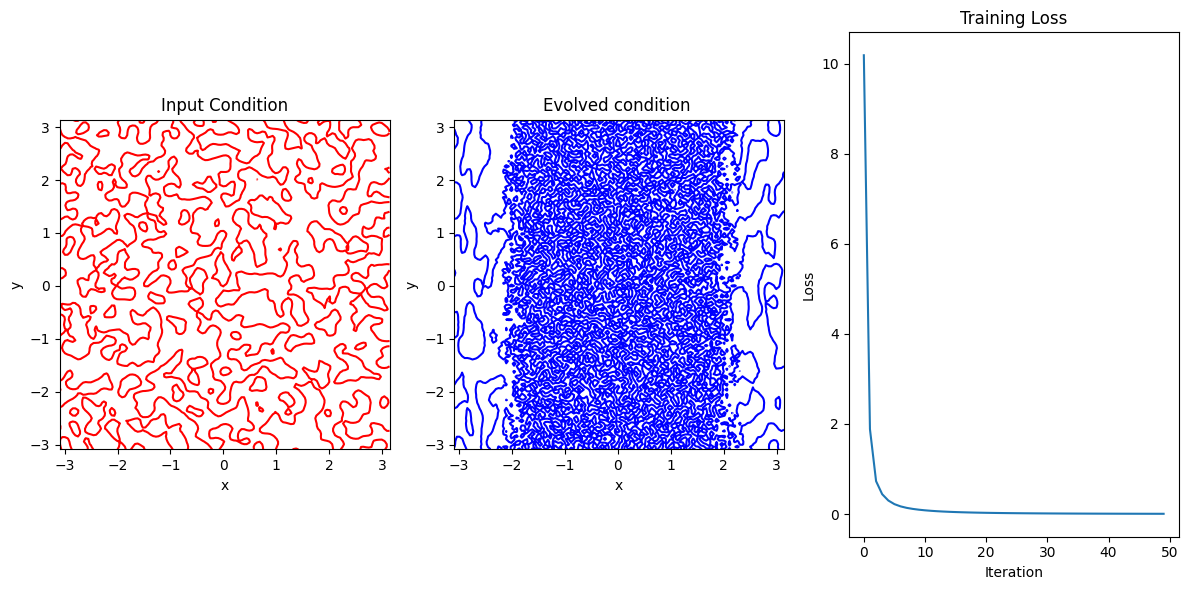

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.example_libraries.stax import Dense, Gelu, serial
from jax.example_libraries.optimizers import optimizer, make_schedule
# from jax.scipy.fftpack import fftn, ifftn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from functools import partial
from jax.numpy.fft import fftn, ifftn, fftshift, ifftshift
from jax.example_libraries.optimizers import exponential_decay
import jax.numpy.fft as jfft
from jax.example_libraries.stax import Dense, Gelu, serial, glorot_normal
from spifol_archs import FNOBlock2D, Permute, complex_adam, MLP, modified_MLP




def fft2(x):
   """Applies a 2D FFT over the first two dimensions of the input array x."""
   return fftn(x, axes=(0, 1))


def ifft2(x):
   """Applies a 2D inverse FFT over the first two dimensions of the input array x."""
   return ifftn(x, axes=(0, 1))




# Define normalization and denormalization functions
def normalize(data):
   mean = jnp.mean(data)
   std = jnp.std(data)
   return (data - mean) / std, mean, std


def denormalize(data, mean, std):
   return data * std + mean

# this is new way of normalization and denormalization for checking 
# def normalize_min_max(data):
#     min_val = jnp.min(data)
#     max_val = jnp.max(data)
#     return (data - min_val) / (max_val - min_val), min_val, max_val

# def denormalize_min_max(data, min_val, max_val):
#     return data * (max_val - min_val) + min_val









class SPiFOL:
   def __init__(self, L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers, mlp_layers,lr, arch):
       self.arch = arch
       self.N = N
       self.lr = lr
       # self.norm_par = norm_par
       self.eps = eps
       self.pp2 = pp2
       self.qq2 = qq2
       self.dt = dt
       self.L = L
       self.h = h
       self.x = x
       self.y = y
       # Initialize the network based on architecture type
       if arch == 'FNO':
           self.N_init, self.N_apply = serial(*fno_layers)
           _, params = self.N_init(random.PRNGKey(1234), (-1, N, N, 3))
          
       elif arch == 'MLP':
           self.N_init, self.N_apply = MLP(mlp_layers)
           params = self.N_init(random.PRNGKey(1234))
          
       elif arch == 'modified_MLP':
           self.N_init, self.N_apply = modified_MLP(mlp_layers)
           params = self.N_init(random.PRNGKey(1234))
       else:
           raise ValueError("Unsupported architecture!")


       self.params = params


    
       # Optimizer setup
       self.opt_init, self.opt_update, self.get_params = complex_adam(
           jax.example_libraries.optimizers.exponential_decay(
               lr, decay_steps=2000, decay_rate=0.9)
           )
      
       self.opt_state = self.opt_init(self.params)


       # Logging losses
       self.total_loss_log = []
       self.total_energy_loss_log = []


       # Initialize optimizer state
       self.opt_state = self.opt_init(self.params)
       self.itercount = iter(range(50000))


   @partial(jit, static_argnums=(0,))
   def operator_net(self, params, uk):
       if self.arch == 'FNO':
        #    print(f'uk ko shape before reshape inside operator net.{uk.shape}')
           uk = uk.reshape(uk.shape[0], self.N, self.N, uk.shape[3])  # Reshape input 
           O = self.N_apply(params, uk)  # Apply the FNO network
        #    print(f'o ko shape after network output.{O.shape}')

           O = jnp.real(O)  # Take the real part of the output
           O = O.reshape(uk.shape[0],self.N, self.N, uk.shape[3])  # Reshape output
        #    print(f'o ko shape after reshape.{O.shape}')

           return O
       elif self.arch == 'MLP':
           uk = uk.flatten()
           O = self.N_apply(params, uk)  # Directly apply the network
           O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])  # Reshape output to match strain components
           # O = O / self.norm_par  # Normalize the output
           return O
       elif self.arch == 'modified_MLP':
           uk = uk.flatten()
           O = self.N_apply(params, uk)
           O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])
           return O
       else:
           raise ValueError("Unsupported architecture type!")
      

   def allen_cahn_equation(self, uk, total_steps=100):
         # Expand pp2 and qq2 to include a channel dimension
        self.pp2 = jnp.expand_dims(self.pp2, axis=(0, -1))  # (128, 128) -> (1, 128, 128, 1)
        self.qq2 = jnp.expand_dims(self.qq2, axis=(0, -1))  # (128, 128) -> (1, 128, 128, 1)

        # Broadcast pp2 and qq2 to match the shape of uk
        self.pp2 = jnp.broadcast_to(self.pp2, (uk.shape[0], self.N, self.N, uk.shape[3]))  # (1, 128, 128, 1) -> (1, 128, 128, 3)
        self.qq2 = jnp.broadcast_to(self.qq2, (uk.shape[0], self.N, self.N, uk.shape[3]))  # (1, 128, 128, 1) -> (1, 128, 128, 3)

        # for _ in range(total_steps):

        cahn = eps**2
        uk = jnp.real(uk)

        # Check shapes for debugging
        # print(f"pp2 shape after broadcasting: {self.pp2.shape}")  # Expected: (1, 128, 128, 3)
        # print(f"qq2 shape after broadcasting: {self.qq2.shape}")  # Expected: (1, 128, 128, 3)
        # print(f"uk shape before broadcasting: {uk.shape}")  # Expected: (1, 128, 128, 3)

        # Compute denominator in Fourier space
        denominator = cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2))  # Shape: (1, 128, 128, 3)
        # print(f"denominator shape: {denominator.shape}")  # Expected: (1, 128, 128, 3)

        # Perform FFT calculations
        s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk))  # Shape: (1, 128, 128, 3)
        v_hat = s_hat / denominator  # Shape: (1, 128, 128, 3)
        uk = jfft.ifft2(v_hat)  # Shape: (1, 128, 128, 3)

        # Check results
        # print(f"s_hat shape: {s_hat.shape}")  # Expected: (1, 128, 128, 3)
        # print(f"v_hat shape: {v_hat.shape}")  # Expected: (1, 128, 128, 3)
        # print(f"uk shape after computation: {uk.shape}")  # Expected: (1, 128, 128, 3)

        return jnp.real(uk)  # Return only the real part
   


   @partial(jit, static_argnums=(0,))
   def loss_single(self, params, uk):
        u_nn = self.operator_net(params, uk) # predicted or next value of the initial condition
        u_nn = u_nn.reshape(-1, self.N, self.N, uk.shape[3])
        # print(f'[u_nn ko shape : {u_nn.shape}')

        u_ac = self.allen_cahn_equation(uk)
        
        # Allen-Cahn equation loss
        # energy_loss = self.total_energy(u_pred)
        datadriven_loss = jnp.mean((u_ac - u_nn) ** 2)
        # total_loss = datadriven_loss + energy_loss
        return datadriven_loss
   

   @partial(jit, static_argnums=(0,))
   def step(self, i, opt_state, uk):
        params = self.get_params(opt_state)
        grads = grad(self.loss_single)(params, uk)
        return self.opt_update(i, grads, opt_state)


   def train(self, uk, nIter=1000):
        pbar = trange(nIter)
        for it in pbar:
            self.opt_state = self.step(next(self.itercount), self.opt_state, uk)
    #    self.itercount = iter(range(nIter))  # Create an iterator
            



            # Logger (log the loss every 100 iterations)
            if it % 10 == 0:
                params = self.get_params(self.opt_state)
                loss = self.loss_single(params, uk)
                self.total_loss_log.append(loss)
                # self.total_energy_loss_log.append(energy_loss)
                pbar.set_postfix({'Loss': loss})

   
#         # Modify the train method to support batching
#    def train(self, uk, batch_size=64, nIter=2000):
#             # Split the data into batches
#         num_batches = uk.shape[0] // batch_size
#         pbar = trange(nIter)
        
#         for it in pbar:
#             for batch_idx in range(num_batches):
#                 # Create a batch of data
#                 batch_start = batch_idx * batch_size
#                 batch_end = batch_start + batch_size
#                 batch_data = uk[batch_start:batch_end]  # Slice the batch
                
#                 # Perform optimization step for the batch
#                 self.opt_state = self.step(next(self.itercount), self.opt_state, batch_data)

#             # Logger (log the loss every 10 iterations)
#             if it % 100 == 0:
#                 params = self.get_params(self.opt_state)
#                 loss = self.loss_single(params, uk)  # Compute loss for full dataset
#                 self.total_loss_log.append(loss)
#                 pbar.set_postfix({'Loss': loss})





# Parameters
N = 128 # no. of grid points
eps = 0.05 # epsillon 
lr = 0.001 # learning rate
dt = 0.0001 # time step or time increment
L = 2 * jnp.pi # length of domian
h = L/N # spacing between grid or length of grid





x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)


theta = jnp.arctan2(y, x)
# Generate input condition
xx, yy = jnp.meshgrid(x, y)
# input_condition = jnp.tanh((2 - jnp.sqrt(xx**2 + yy**2)) / jnp.sqrt(2)* eps)
# input_condition = np.load (os.path.join(save_dir, "u_train.npy"), np.array(data.u_train))
# Load the .npy file
input_condition = np.load('data_generation/u_test.npy')
input_condition = input_condition[:200]

# Inspect the data
# print(input_condition)
# print(type(input_condition)) 


 # defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2 , 0)])




# # square of wavenumber in x and y direction
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction


# # creating meshgrid in x and y direction for square of wavenumber
pp2, qq2 = jnp.meshgrid(p2, q2)



# arch_list = ['FNO', 'MLP', 'modified_MLP']
arch_list = ['FNO']
# arch = 'modified_MLP'
# mlp layers
mlp_layers = [16384, 32, 32, 16384]


# Define FNO layers
fno_layers = [
   Dense(32),
   Permute("ijkl->iljk"),
   FNOBlock2D(32),
   Gelu,  # activation can be changed here
   FNOBlock2D(32),
   Gelu,
   FNOBlock2D(32),
   Permute("ijkl->iklj"),
   Dense(128),
   Gelu,
   Dense(3),
]



cahn = eps**2
for arch in arch_list:
   # Initialize and train the model
    model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers,mlp_layers,lr, arch)
    # final_state = model.allen_cahn_equation(input_condition)
    # In your main code:
    # batch_size = 64  # Set the desired batch size
    # model.train(input_condition, batch_size=batch_size, nIter=2000)
    model.train(input_condition, nIter=500)




params = model.get_params(model.opt_state)
model_prediction = model.operator_net(params, input_condition)

# model_prediction = denormalize(model_prediction, mean, std)




# Plot the initial and final states
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

# Input condition plot
# axs[0].contour(x, y, jnp.real(input_condition[0].T), levels=[0], colors="black")
# axs[0].contour(x, y, jnp.real(model_prediction[0].T), levels=[0], colors="red")

input_condition = input_condition[0, :, :, 0]  # This extracts the 2D array of shape (128, 128)
model_prediction = model_prediction[0, :, :, 0]  # This extracts the 2D array of shape (128, 128)
# print(input_condition.shape)  # Expected: (128, 128) or similar
# print(model_prediction.shape)  # Expected: (128, 128) or similar
# print("Input mean:", jnp.mean(input_condition))
# print("Prediction mean:", jnp.mean(model_prediction))
print("Input Condition Statistics:")
print(f"Min: {jnp.min(input_condition)}, Max: {jnp.max(input_condition)}")
print("Model Prediction Statistics:")
print(f"Min: {jnp.min(model_prediction)}, Max: {jnp.max(model_prediction)}")





# axs[0].imshow(input_condition)
axs[0].contour(x, y, jnp.real(input_condition.T), levels=[0], colors="red")
# axs[0].contour(x, y, jnp.real(model_prediction.T), levels=[0], colors="blue")

axs[0].set_title('Input Condition')
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')


axs[1].contour(x, y, jnp.real(model_prediction.T), levels=[0], colors="blue")
# axs[1].imshow(model_prediction)
axs[1].set_title('Evolved condition ')
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')


# #    # Plot loss
axs[2].plot(model.total_loss_log)
axs[2].set_title('Training Loss')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Loss')

# plt.plot(model.total_loss_log)
# plt.title("Training Loss Over Iterations")
# plt.xlabel("Iteration")
# plt.ylabel("Loss")
# plt.show()







plt.tight_layout() 
plt.show()

            

IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed

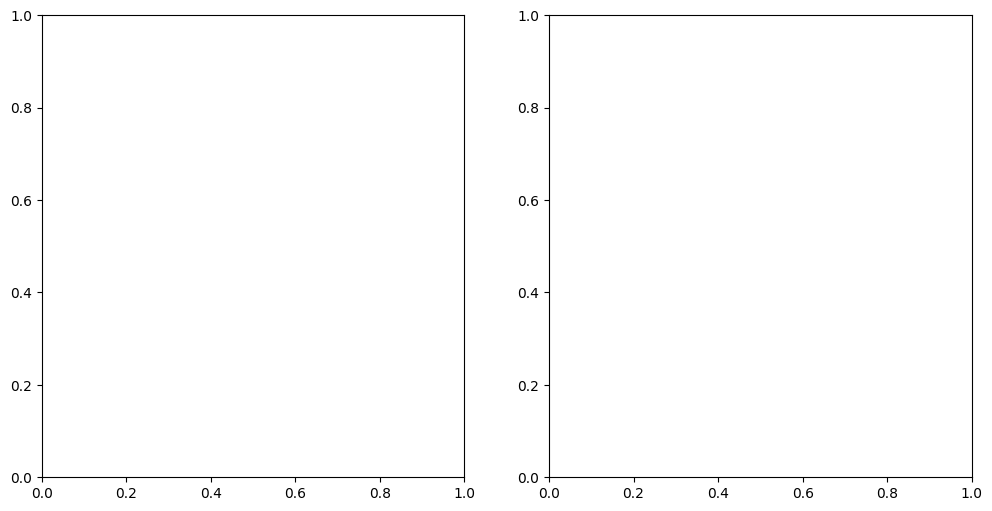

In [42]:
# Plot the initial and final states
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Extract the 2D arrays
input_condition = input_condition[0, :, :, 0]  # Shape: (128, 128)
model_prediction = model_prediction[0, :, :, 0]  # Shape: (128, 128)

# Check shapes
print("Input condition shape:", input_condition.shape)
print("Model prediction shape:", model_prediction.shape)

# Create a meshgrid for x and y if necessary
x, y = jnp.meshgrid(x, y)  # Ensure x and y are compatible
print("x shape:", x.shape, "y shape:", y.shape)

# Plot input condition and model prediction contours
axs[0].contour(x, y, jnp.real(input_condition.T), levels=10, cmap="Reds", alpha=0.6)
axs[0].contour(x, y, jnp.real(model_prediction.T), levels=10, cmap="Blues", alpha=0.6)
axs[0].set_title('Input Condition and Prediction')
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# Plot training loss
if hasattr(model, "total_loss_log"):
    axs[1].plot(model.total_loss_log)
    axs[1].set_title('Training Loss')
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Loss')
else:
    print("No loss log found in model.")

# Finalize layout
plt.tight_layout()
plt.show()


TypeError: Input z must be 2D, not 4D

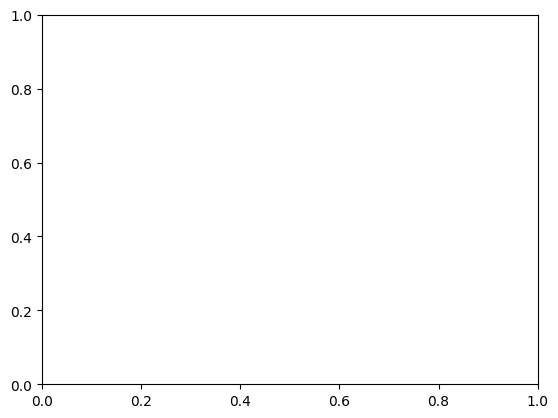

In [ ]:
import jax
import numpy as np
import jax.random as random
import jax.numpy as jnp
import jax.numpy.fft as jfft
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from numpy import sqrt
from numpy import round
from matplotlib import pyplot as plt
from matplotlib import contour
from jax.numpy.fft import fft2, ifft2
from jax.numpy.fft import fftn, ifftn
from numpy import real
from jax.example_libraries.stax import serial, Gelu
from jax.example_libraries.optimizers import optimizer, make_schedule
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter






# difinning the no of grid points in x, y and z
Nx = 128 # number of grid points in x be positive even integer number
Ny = 128 # number of grid points in y be positive even integer number
Nz = 128 # number of grid points in z be positive even integer number



# Define the parameters of the Allen-Cahn equation in 2d
Lx = 2.0 * jnp.pi #length of the domain in x
Ly = 2.0 * jnp.pi #length of the domain in y
hx = Lx / Nx #spatial step size in coordinate x
hy = Ly / Ny #spatial step size in coordinate y
dt = 0.0001 #time step size
T = 4 #final time
Nt = int(jnp.round(T/dt)) #number of time steps
ns = Nt / 10 #number of snapshots

# Define the grid points in x and y direction
def x_gridpoint(Nx, Lx, hx):
    x = jnp.linspace(-0.5*Lx+hx,0.5*Lx,Nx)
    return x
x = x_gridpoint(Nx, Lx, hx) #number of grid points in x direction and step size and limitation on x  axis
def y_gridpoint(Ny, Ly, hy):
    y = jnp.linspace(-0.5*Ly+hy,0.5*Ly,Ny)
    return y
y = y_gridpoint(Ny, Ly, hy) #number of grid points in y direction and step size and limitation on y  axis 

# creating meshgrid in x and y direction
xx,yy = jnp.meshgrid(x,y) #creating meshgrid in x and y direction 

# defining parameters for the Allen-Cahn equation
#It determines the scale of the transition region (interface width) between phases. its the width of the interface, smaller epsillon refer to the sharp transition

epsillon = 0.05 #small parameter # interface thickness in the Allen-Cahn equation 
cahn = epsillon**2 #cahn number  

# initial condition of allen cahn equation
# uk =jnp.tanh((2 -sqrt(xx**2 + yy**2)) / (sqrt(2) *epsillon)) #initial condition of allen cahn equation
# theta = jnp.arctan(y/x)
# u =jnp.tanh((1.7 - 1.2 * jnp.cos(6*theta) - sqrt(xx**2 + yy**2)) / (sqrt(2) *epsillon))
uk = np.load('data_generation/u_test.npy')
print("uk shape:", uk.shape)

uk_2d = uk[0, :, :, 0]  # Extract the first sample and the first channel.
print("Reduced uk shape:", uk_2d.shape)  # Should now be (128, 128)


# defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / Lx * jnp.arange(0, Nx//2), 2 * jnp.pi / Lx * jnp.arange(-Nx//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / Ly * jnp.arange(0, Ny//2), 2 * jnp.pi / Ly * jnp.arange(-Ny//2 , 0)])


# square of wavenumber in x and y direction
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction

# creating meshgrid in x and y direction for square of wavenumber
pp2, qq2 = jnp.meshgrid(p2, q2)
#print(pp2.shape) # creating meshgrid in x and y direction for square of wavenumber


# # plotting the initial condition of the Allen-Cahn equation


#this figure code is pervious code 
figure1 = plt.figure()
plt.contour(x, y, jnp.real(uk.T), [0], colors = 'black')
plt.gca().set_aspect('equal', adjustable='box') 
plt.title('Initial condition')
plt.xlabel('x')
plt.ylabel('y')
# plt.show()


# # providing the range of iteration

for iter in range(1, Nt):
    u = jnp.real(uk)
    # print(f'real space u ko size ={u.shape}')
    # Transforming the solution to the discrete Fourier space
    s_hat = jfft.fft2(cahn * u - dt * (u**3 - 3 * u)) # us is the real space
    # print(f's_hat ko size = {s_hat.shape}')
    v_hat = s_hat / (cahn + dt * (2 + cahn * (pp2 + qq2)))  # Allen-Cahn equation
    uk = jfft.ifft2(v_hat)  # u_k+1 result
    # print(f'inverse u ko size = {u.shape}')



    if iter == 100:
        plt.contour(x, y, jnp.real(uk.T), [0], colors='red')
        plt.gca().set_aspect('equal', adjustable='box')
        
    if iter == 4000:
        plt.contour(x, y, jnp.real(uk.T), [0], colors='green')
        plt.gca().set_aspect('equal', adjustable='box')
    
    if iter == 10000:
        plt.contour(x, y, jnp.real(uk.T), [0], colors='blue')
        plt.gca().set_aspect('equal', adjustable='box')

    if iter == 20000:
        plt.contour(x, y, jnp.real(uk.T), [0], colors='pink')
        plt.gca().set_aspect('equal', adjustable='box')


plt.title('Numerical Solutions after iteration ' + str(Nt))
plt.show()



## In this cell input condition given as a batch

Data train: (20, 128, 128, 3)


  0%|          | 0/2500 [00:00<?, ?it/s]

uk ko shape before step:(20, 128, 128, 3)
uk ko shape before reshape inside operator net.(128, 128, 3)
input_fno ko shape after reshape inside operator net.(1, 128, 128, 3)
o ko shape after apply.(1, 128, 128, 3)
o ko shape after reshape.(128, 128, 3)
[u_nn ko shape on loss single : (128, 128, 3)
pp2 shape after expanding: (1, 128, 128, 1)
pp2 shape after broadcasting: (1, 128, 128, 3)
uk ko shape as input:(128, 128, 3)
uk ko shape after inverse:(128, 128, 3)
Min: Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=6/0)>, Max: Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=6/0)>


c:\Users\Manju\Documents\python\envs\myenv\lib\site-packages\jax\_src\lax\lax.py:2785: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
100%|██████████| 2500/2500 [2:13:35<00:00,  3.21s/it, Loss=5.5282122e-05]  


Input Condition Statistics:
Min: -1.0, Max: 0.9999998807907104
Model Prediction Statistics:
Min: -0.9972785115242004, Max: 1.0093635320663452


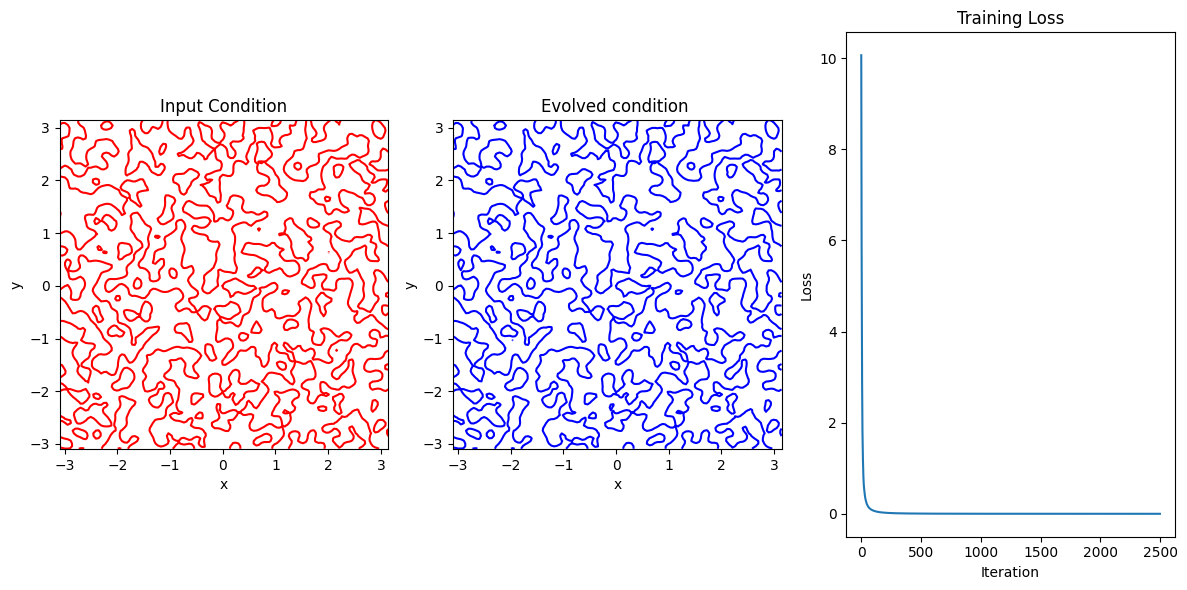

In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.example_libraries.stax import Dense, Gelu, serial
from jax.example_libraries.optimizers import optimizer, make_schedule
# from jax.scipy.fftpack import fftn, ifftn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from functools import partial
from jax.numpy.fft import fftn, ifftn, fftshift, ifftshift
from jax.example_libraries.optimizers import exponential_decay
import jax.numpy.fft as jfft
from jax.example_libraries.stax import Dense, Gelu, serial, glorot_normal
from spifol_archs import FNOBlock2D, Permute, complex_adam, MLP, modified_MLP
from jax import vmap
from torch.utils import data
from jax import lax




def fft2(x):
   """Applies a 2D FFT over the first two dimensions of the input array x."""
   return fftn(x, axes=(0, 1))


def ifft2(x):
   """Applies a 2D inverse FFT over the first two dimensions of the input array x."""
   return ifftn(x, axes=(0, 1))


# Data genrator to make randomized batches
class DataGenerator(data.Dataset):
    def __init__(self, u,
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u # input sample

        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        u = self.__data_generation(subkey)
        return u

    #@partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        u = self.u[idx,:]
        # Construct batch
        return u




class SPiFOL:
    def __init__(self, L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers, mlp_layers,lr, arch):
        self.arch = arch
        self.N = N
        self.lr = lr
        # self.norm_par = norm_par
        self.eps = eps
        self.pp2 = pp2
        self.qq2 = qq2
        self.dt = dt
        self.L = L
        self.h = h
        self.x = x
        self.y = y
        # Initialize the network based on architecture type
        if arch == 'FNO':
            self.N_init, self.N_apply = serial(*fno_layers)
            _, params = self.N_init(random.PRNGKey(1234), (-1, N, N, 3))
            
        elif arch == 'MLP':
            self.N_init, self.N_apply = MLP(mlp_layers)
            params = self.N_init(random.PRNGKey(1234))
            
        elif arch == 'modified_MLP':
            self.N_init, self.N_apply = modified_MLP(mlp_layers)
            params = self.N_init(random.PRNGKey(1234))
        else:
            raise ValueError("Unsupported architecture!")


        self.params = params



        # Optimizer setup
        self.opt_init, self.opt_update, self.get_params = complex_adam(
            jax.example_libraries.optimizers.exponential_decay(
                lr, decay_steps=2000, decay_rate=0.9)
            )

        self.opt_state = self.opt_init(self.params)


        # Logging losses
        self.total_loss_log = []
        self.total_energy_loss_log = []


        # Initialize optimizer state
        self.opt_state = self.opt_init(self.params)
        self.itercount = iter(range(50000))


    
        
     

    # @jax.jit
    def normalize(self,data):
        min_val = jnp.min(data, axis=(0, 1))
        max_val = jnp.max(data, axis=(0, 1))
        range_val = max_val - min_val
        range_val = jnp.where(range_val == 0, 1, range_val)  # Avoid division by zero
        normalized_data = 2 * (data - min_val) / range_val - 1
        return normalized_data

    
    @partial(jit, static_argnums=(0,))
    def operator_net(self, params, uk):
        if self.arch == 'FNO':
            print(f'uk ko shape before reshape inside operator net.{uk.shape}')
        #    uk = uk.reshape(uk.shape[0], self.N, self.N, uk.shape[3])  # Reshape input 
            input_FNO = uk.reshape(-1, self.N, self.N, 3)  # Reshape for FNO
            print(f'input_fno ko shape after reshape inside operator net.{input_FNO.shape}')


            O = self.N_apply(params, input_FNO)  # Apply the FNO network
            print(f'o ko shape after apply.{O.shape}')

        #    O = jnp.real(O)  # Take the real part of the output
            O = O.reshape(self.N, self.N, 3)  # Reshape output
            print(f'o ko shape after reshape.{O.shape}')


            return O
        elif self.arch == 'MLP':
            uk = uk.flatten()
            O = self.N_apply(params, uk)  # Directly apply the network
            O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])  # Reshape output to match strain components
            # O = O / self.norm_par  # Normalize the output
            return O
        elif self.arch == 'modified_MLP':
            uk = uk.flatten()
            O = self.N_apply(params, uk)
            O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])
            return O
        else:
            raise ValueError("Unsupported architecture type!")
      

    def allen_cahn_equation(self, uk, total_steps=500):
            # Expand pp2 and qq2 to include a channel dimension
        self.pp2 = jnp.expand_dims(self.pp2, axis=(0, -1))  # (128, 128) -> (1, 128, 128, 1)
        self.qq2 = jnp.expand_dims(self.qq2, axis=(0, -1))  # (128, 128) -> (1, 128, 128, 1)
        print(f'pp2 shape after expanding: {self.pp2.shape}')  # Expected: (1, 128, 128, 1)

        # Broadcast pp2 and qq2 to match the shape of uk
        self.pp2 = jnp.broadcast_to(self.pp2, (1, self.N, self.N, 3))  # (1, 128, 128, 1) -> (1, 128, 128, 3)
        self.qq2 = jnp.broadcast_to(self.qq2, (1, self.N, self.N, 3))  # (1, 128, 128, 1) -> (1, 128, 128, 3)
        print(f'pp2 shape after broadcasting: {self.pp2.shape}')  # Expected: (1, 128, 128, 3)

        # for _ in range(total_steps):

        cahn = eps**2
        uk = jnp.real(uk)
        print(f'uk ko shape as input:{uk.shape}')

        # Check shapes for debugging
        # print(f"pp2 shape after broadcasting: {self.pp2.shape}")  # Expected: (1, 128, 128, 3)
        # print(f"qq2 shape after broadcasting: {self.qq2.shape}")  # Expected: (1, 128, 128, 3)
        # print(f"uk shape before broadcasting: {uk.shape}")  # Expected: (1, 128, 128, 3)

        # Compute denominator in Fourier space
        denominator = cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2))  # Shape: (1, 128, 128, 3)
        # print(f"denominator shape: {denominator.shape}")  # Expected: (1, 128, 128, 3)

        # Perform FFT calculations
        s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk))  # Shape: (1, 128, 128, 3)
        v_hat = s_hat / denominator  # Shape: (1, 128, 128, 3)
        uk = jfft.ifft2(v_hat)  # Shape: (1, 128, 128, 3)
        uk = uk.reshape(self.N, self.N, 3)
        print(f'uk ko shape after inverse:{uk.shape}')
        
        uk_normalized = self.normalize(jnp.real(uk))
        print(f"Min: {jnp.min(jnp.real(uk_normalized))}, Max: {jnp.max(jnp.real(uk_normalized))}")
        

        return uk_normalized # Return only the real part



    @partial(jit, static_argnums=(0,))
    def loss_single(self, params, uk):
        u_nn = self.operator_net(params, uk) # predicted or next value of the initial condition
        u_nn = u_nn.reshape(self.N, self.N, 3)
        print(f'[u_nn ko shape on loss single : {u_nn.shape}')

        u_ac = self.allen_cahn_equation(uk)
        
        # Allen-Cahn equation loss
        # energy_loss = self.total_energy(u_pred)
        datadriven_loss = jnp.mean((u_ac - u_nn) ** 2)
        # total_loss = datadriven_loss + energy_loss
        return datadriven_loss

    @partial(jit, static_argnums=(0,))
    def loss_batches(self, params, batch):
        # batch losses
        batch_loss = vmap(self.loss_single, (None, 0))(params, batch)
        batch_loss  = jnp.mean(batch_loss)
        
        return batch_loss


    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, uk):
        params = self.get_params(opt_state)
        print(f'uk ko shape before step:{uk.shape}')
        grads = grad(self.loss_batches)(params, uk)
        return self.opt_update(i, grads, opt_state)


    def train(self, dataset, nIter=1000):
        data = iter(dataset)
        pbar = trange(nIter)
        for it in pbar:
            batch = next(data)
            batch = jnp.array(batch)
            # print(f'batch ko shape:{batch.shape}')
            # print(f'next itercount :{next(self.itercount)}')
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)
            # self.opt_state = self.step(next(self.itercount), self.opt_state, uk)
    #    self.itercount = iter(range(nIter))  # Create an iterator
            


             # Logger (log the loss every 100 iterations)
            params = self.get_params(self.opt_state)
            loss = self.loss_batches(params, batch)
            self.total_loss_log.append(loss)
            # self.total_energy_loss_log.append(energy_loss)
            pbar.set_postfix({'Loss': loss})


            # # Logger (log the loss every 100 iterations)
            # if it % 10 == 0:
            #     params = self.get_params(self.opt_state)
            #     loss = self.loss_batches(params, batch)
            #     self.total_loss_log.append(loss)
            #     # self.total_energy_loss_log.append(energy_loss)
            #     pbar.set_postfix({'Loss': loss})

    #    def train(self, uk, batch_size=32, nIter=1000):
    #         num_batches = uk.shape[0] // batch_size
    #         pbar = trange(nIter)
    #         for it in pbar:
    #             for batch_idx in range(num_batches):
    #                 batch_start = batch_idx * batch_size
    #                 batch_end = batch_start + batch_size
    #                 batch_data = uk[batch_start:batch_end]
    #                 self.opt_state = self.step(next(self.itercount), self.opt_state, batch_data)
    #             if it % 10 == 0:
    #                 params = self.get_params(self.opt_state)
    #                 loss = self.loss_single(params, uk)
    #                 self.total_loss_log.append(loss)
    #                 pbar.set_postfix({'Loss': loss})



    #         # Modify the train method to support batching
    #    def train(self, uk, batch_size=64, nIter=2000):
    #             # Split the data into batches
    #         num_batches = uk.shape[0] // batch_size
    #         pbar = trange(nIter)
        
    #         for it in pbar:
    #             for batch_idx in range(num_batches):
    #                 # Create a batch of data
    #                 batch_start = batch_idx * batch_size
    #                 batch_end = batch_start + batch_size
    #                 batch_data = uk[batch_start:batch_end]  # Slice the batch
                
    #                 # Perform optimization step for the batch
    #                 self.opt_state = self.step(next(self.itercount), self.opt_state, batch_data)

    #             # Logger (log the loss every 10 iterations)
    #             if it % 100 == 0:
    #                 params = self.get_params(self.opt_state)
    #                 loss = self.loss_single(params, uk)  # Compute loss for full dataset
    #                 self.total_loss_log.append(loss)
    #                 pbar.set_postfix({'Loss': loss})






# Parameters
N = 128 # no. of grid points
eps = 0.05 # epsillon 
lr = 0.001 # learning rate
dt = 0.0001 # time step or time increment
L = 2 * jnp.pi # length of domian
h = L/N # spacing between grid or length of grid





x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)


theta = jnp.arctan2(y, x)
# Generate input condition
xx, yy = jnp.meshgrid(x, y)
# input_condition = jnp.tanh((2 - jnp.sqrt(xx**2 + yy**2)) / jnp.sqrt(2)* eps)
# input_condition = np.load (os.path.join(save_dir, "u_train.npy"), np.array(data.u_train))
# Load the .npy file
input_condition = np.load('data_generation/u_test.npy')
# input_condition = input_condition[:2000]
# batch_size = 32  # Choose an appropriate batch size
# num_batches = input_condition.shape[0] // batch_size



# Inspect the data
# print(input_condition)
# print(type(input_condition)) 


 # defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2 , 0)])




# # square of wavenumber in x and y direction
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction


# # creating meshgrid in x and y direction for square of wavenumber
pp2, qq2 = jnp.meshgrid(p2, q2)



# arch_list = ['FNO', 'MLP', 'modified_MLP']
arch_list = ['FNO']
# arch = 'modified_MLP'
# mlp layers
mlp_layers = [16384, 32, 32, 16384]


# Define FNO layers
fno_layers = [
   Dense(32),
   Permute("ijkl->iljk"),
   FNOBlock2D(32),
   Gelu,  # activation can be changed here
   FNOBlock2D(32),
   Gelu,
   FNOBlock2D(32),
   Permute("ijkl->iklj"),
   Dense(128),
   Gelu,
   Dense(3),
]



cahn = eps**2
# Generate the data trainig samples
# input_condition = input_condition[:,:,:,0]
data_train = DataGenerator(input_condition, batch_size=20)

print("Data train:", data_train[0].shape)


for arch in arch_list:
#    # Initialize and train the model
    model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers,mlp_layers,lr, arch)
#     # final_state = model.allen_cahn_equation(input_condition)
#     # In your main code:
   
    model.train(data_train, nIter=2500)
#     # batch_size = 64  # Example batch size
#     # model.train(input_condition, batch_size=batch_size, nIter=10)





params = model.get_params(model.opt_state)
model_prediction = model.operator_net(params, data_train[0][0])


print("Input Condition Statistics:")
print(f"Min: {jnp.min(input_condition)}, Max: {jnp.max(input_condition)}")
print("Model Prediction Statistics:")
print(f"Min: {jnp.min(model_prediction)}, Max: {jnp.max(model_prediction)}")









# Plot the initial and final states
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

# Input condition plot
# axs[0].contour(x, y, jnp.real(input_condition[0].T), levels=[0], colors="black")
# axs[0].contour(x, y, jnp.real(model_prediction[0].T), levels=[0], colors="red")

# input_condition = input_condition[0, :, :, 0]  # This extracts the 2D array of shape (128, 128)
# model_prediction = model_prediction[0, :, :, 0]  # This extracts the 2D array of shape (128, 128)
# print(input_condition.shape)  # Expected: (128, 128) or similar
# print(model_prediction.shape)  # Expected: (128, 128) or similar
# print("Input mean:", jnp.mean(input_condition))
# print("Prediction mean:", jnp.mean(model_prediction))





plt_train = jnp.real(data_train[0][0])
plt_train = plt_train[:,:,0]
plt_pred = jnp.real(model_prediction)
plt_pred = plt_pred[:,:,0]

# axs[0].imshow(input_condition)
axs[0].contour(x, y,plt_train , levels=[0], colors="red")
# axs[0].contour(x, y, jnp.real(model_prediction.T), levels=[0], colors="blue")

axs[0].set_title('Input Condition')
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')


axs[1].contour(x, y, plt_pred, levels=[0], colors="blue")
# axs[1].imshow(model_prediction)
axs[1].set_title('Evolved condition ')
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')


# #    # Plot loss
axs[2].plot(model.total_loss_log)
axs[2].set_title('Training Loss')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Loss')

# plt.plot(model.total_loss_log)
# plt.title("Training Loss Over Iterations")
# plt.xlabel("Iteration")
# plt.ylabel("Loss")
# plt.show()







plt.tight_layout() 
plt.show()

            

## this cell for batch training , this cell is importance for training but we need to new input data upload 

data_train ko shape:(20, 128, 128, 3)


  0%|          | 0/2 [00:00<?, ?it/s]

 batch ko size : (20, 128, 128, 3)
uk ko shape before reshape inside operator net.(128, 128, 3)
input_fno ko shape after reshape inside operator net.(1, 128, 128, 3)
o ko shape after apply.(1, 128, 128, 3)
o ko shape after reshape.(128, 128, 3)


c:\Users\Manju\Documents\python\envs\myenv\lib\site-packages\jax\_src\lax\lax.py:2785: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
100%|██████████| 2/2 [09:22<00:00, 281.24s/it, Epoch=2, Batch=95, Loss=0.025649128]


Input Condition Statistics:
Min: -1.0, Max: 1.0
Model Prediction Statistics:
Min: -0.35633358359336853, Max: 0.3770114481449127


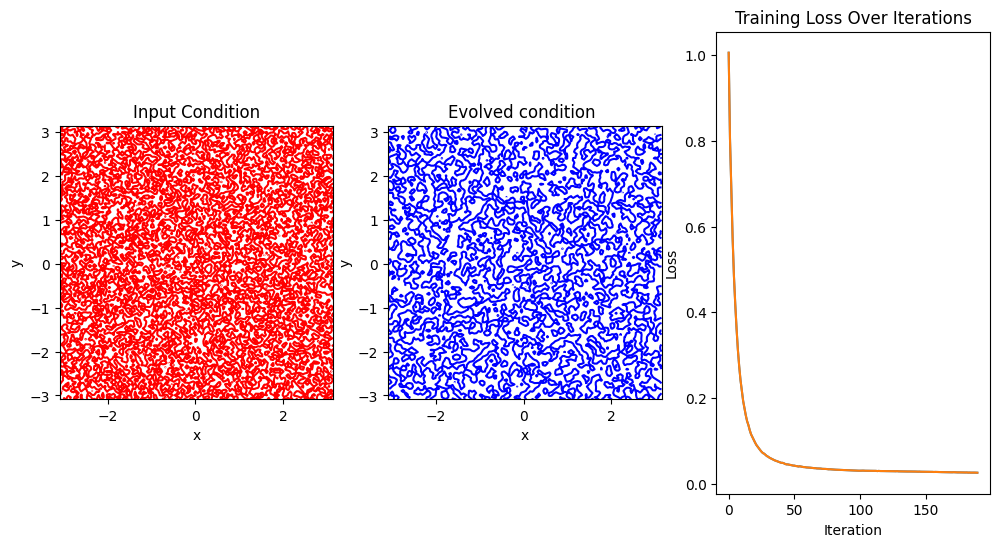

<Figure size 640x480 with 0 Axes>

In [7]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.example_libraries.stax import Dense, Gelu, serial
from jax.example_libraries.optimizers import optimizer, make_schedule
# from jax.scipy.fftpack import fftn, ifftn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from functools import partial
from jax.numpy.fft import fftn, ifftn, fftshift, ifftshift
from jax.example_libraries.optimizers import exponential_decay
import jax.numpy.fft as jfft
from jax.example_libraries.stax import Dense, Gelu, serial, glorot_normal
from spifol_archs import FNOBlock2D, Permute, complex_adam, MLP, modified_MLP
from jax import vmap
from torch.utils import data
from jax import lax
from jax import debug





def fft2(x):
   """Applies a 2D FFT over the first two dimensions of the input array x."""
   return fftn(x, axes=(0, 1))


def ifft2(x):
   """Applies a 2D inverse FFT over the first two dimensions of the input array x."""
   return ifftn(x, axes=(0, 1))


class DataGenerator(data.Dataset):
    def __init__(self, u,
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u  # Input samples
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key
        self.current_idx = 0  # Track the current index for iteration

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        u = self.__data_generation(subkey)
        return u

    def __len__(self):
        'Return the number of batches'
        return self.N // self.batch_size  # Total full batches

    def __iter__(self):
        'Return an iterator that resets itself'
        self.current_idx = 0  # Reset the index
        return self

    def __next__(self):
        'Get the next batch'
        if self.current_idx >= len(self):  # Stop when all batches are processed
            raise StopIteration
        self.current_idx += 1
        return self.__getitem__(self.current_idx)

    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        u = self.u[idx, :]
        return u





class SPiFOL:
    def __init__(self, L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers, mlp_layers,lr, arch):
        self.arch = arch
        self.N = N
        self.lr = lr
        # self.norm_par = norm_par
        self.eps = eps
        self.pp2 = pp2
        self.qq2 = qq2
        self.dt = dt
        self.L = L
        self.h = h
        self.x = x
        self.y = y
        # Initialize the network based on architecture type
        if arch == 'FNO':
            self.N_init, self.N_apply = serial(*fno_layers)
            _, params = self.N_init(random.PRNGKey(1234), (-1, N, N, 3))
            
        elif arch == 'MLP':
            self.N_init, self.N_apply = MLP(mlp_layers)
            params = self.N_init(random.PRNGKey(1234))
            
        elif arch == 'modified_MLP':
            self.N_init, self.N_apply = modified_MLP(mlp_layers)
            params = self.N_init(random.PRNGKey(1234))
        else:
            raise ValueError("Unsupported architecture!")


        self.params = params



        # Optimizer setup
        self.opt_init, self.opt_update, self.get_params = complex_adam(
            jax.example_libraries.optimizers.exponential_decay(
                lr, decay_steps=2000, decay_rate=0.9)
            )

        self.opt_state = self.opt_init(self.params)


        # Logging losses
        self.total_loss_log = []
        self.total_energy_loss_log = []


        # Initialize optimizer state
        self.opt_state = self.opt_init(self.params)
        self.itercount = iter(range(50000))


    
        
     

    # @jax.jit
    def normalize(self,data):
        min_val = jnp.min(data, axis=(0, 1))
        max_val = jnp.max(data, axis=(0, 1))
        range_val = max_val - min_val
        range_val = jnp.where(range_val == 0, 1, range_val)  # Avoid division by zero
        normalized_data = 2 * (data - min_val) / range_val - 1
        return normalized_data

    
    @partial(jit, static_argnums=(0,))
    def operator_net(self, params, uk):
        if self.arch == 'FNO':
            print(f'uk ko shape before reshape inside operator net.{uk.shape}')
        #    uk = uk.reshape(uk.shape[0], self.N, self.N, uk.shape[3])  # Reshape input 
            input_FNO = uk.reshape(-1, self.N, self.N, 3)  # Reshape for FNO
            print(f'input_fno ko shape after reshape inside operator net.{input_FNO.shape}')


            O = self.N_apply(params, input_FNO)  # Apply the FNO network
            print(f'o ko shape after apply.{O.shape}')

        #    O = jnp.real(O)  # Take the real part of the output
            O = O.reshape(self.N, self.N, 3)  # Reshape output
            print(f'o ko shape after reshape.{O.shape}')


            return O
        elif self.arch == 'MLP':
            uk = uk.flatten()
            O = self.N_apply(params, uk)  # Directly apply the network
            O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])  # Reshape output to match strain components
            # O = O / self.norm_par  # Normalize the output
            return O
        elif self.arch == 'modified_MLP':
            uk = uk.flatten()
            O = self.N_apply(params, uk)
            O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])
            return O
        else:
            raise ValueError("Unsupported architecture type!")
      

    def allen_cahn_equation(self, uk, total_steps=500):
        # debug.print("Processing x")  # Prints each x correctly

            # Expand pp2 and qq2 to include a channel dimension
        self.pp2 = jnp.expand_dims(self.pp2, axis=(0, -1))  # (128, 128) -> (1, 128, 128, 1)
        self.qq2 = jnp.expand_dims(self.qq2, axis=(0, -1))  # (128, 128) -> (1, 128, 128, 1)
        # print(f'pp2 shape after expanding: {self.pp2.shape}')  # Expected: (1, 128, 128, 1)

        # Broadcast pp2 and qq2 to match the shape of uk
        self.pp2 = jnp.broadcast_to(self.pp2, (1, self.N, self.N, 3))  # (1, 128, 128, 1) -> (1, 128, 128, 3)
        self.qq2 = jnp.broadcast_to(self.qq2, (1, self.N, self.N, 3))  # (1, 128, 128, 1) -> (1, 128, 128, 3)
        # print(f'pp2 shape after broadcasting: {self.pp2.shape}')  # Expected: (1, 128, 128, 3)

        # for _ in range(total_steps):

        cahn = eps**2
        uk = jnp.real(uk)
        # print(f'uk ko shape as input:{uk.shape}')

        # Check shapes for debugging
        # print(f"pp2 shape after broadcasting: {self.pp2.shape}")  # Expected: (1, 128, 128, 3)
        # print(f"qq2 shape after broadcasting: {self.qq2.shape}")  # Expected: (1, 128, 128, 3)
        # print(f"uk shape before broadcasting: {uk.shape}")  # Expected: (1, 128, 128, 3)

        # Compute denominator in Fourier space
        denominator = cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2))  # Shape: (1, 128, 128, 3)
        # print(f"denominator shape: {denominator.shape}")  # Expected: (1, 128, 128, 3)

        # Perform FFT calculations
        s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk))  # Shape: (1, 128, 128, 3)
        v_hat = s_hat / denominator  # Shape: (1, 128, 128, 3)
        uk = jfft.ifft2(v_hat)  # Shape: (1, 128, 128, 3)
        uk = uk.reshape(self.N, self.N, 3)

        

        return jnp.real(uk) # Return only the real part



    @partial(jit, static_argnums=(0,))
    def loss_single(self, params, uk):
        # print(f'[uk ko shape on loss single : {uk.shape}')

        u_nn = self.operator_net(params, uk) # predicted or next value of the initial condition
        u_nn = u_nn.reshape(self.N, self.N, 3)
        # print(f'[u_nn ko shape on loss single : {u_nn.shape}')

        u_ac = self.allen_cahn_equation(uk)
        
        # Allen-Cahn equation loss
        # energy_loss = self.total_energy(u_pred)
        datadriven_loss = jnp.mean((u_ac - u_nn) ** 2)
        # total_loss = datadriven_loss + energy_loss
        return datadriven_loss

    @partial(jit, static_argnums=(0,))
    def loss_batches(self, params, batch):
        print(f' batch ko size : {batch.shape}')
        # batch losses
        batch_loss = vmap(self.loss_single, (None, 0))(params, batch)
        # debug.print(f'size of batch loss after vmap={batch_loss.shape}')  # Prints each x correctly

        batch_loss  = jnp.mean(batch_loss)
        
        return batch_loss


    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, uk):
        params = self.get_params(opt_state)
        # print(f'uk ko shape before step:{uk.shape}')
        grads = grad(self.loss_batches)(params, uk)
        return self.opt_update(i, grads, opt_state)


   # Update the train method of the SPiFOL class
    def train(self, data_train, num_epochs=1):
        print(f'data_train ko shape:{data_train[0].shape}')
        # Example training loop
        pbar = trange(num_epochs)
        for it in pbar:
            for batch_idx, batch in enumerate(data_train):
                self.opt_state = self.step(batch_idx, self.opt_state, batch)
                params = self.get_params(self.opt_state)
                loss = self.loss_batches(params, batch)
                self.total_loss_log.append(loss)
                pbar.set_postfix({ 'Epoch': it+1, 'Batch': batch_idx+1, 'Loss': loss,})

                # print(f'Epoch: {it}, Batch: {batch_idx}, Loss: {loss}')


        # """Training loop that iterates over all samples in batches."""
        # data_loader = iter(data_generator) # Create an iterable from the data generator
        # print(f'next itercount :{next(self.itercount)}')
        # print(f'data loader:{data_loader}')
        # pbar = trange(nIter)
        # for it in pbar:
        #     try:
        #         batch = next(data_loader)  # Fetch the next batch
        #     except StopIteration:
        #         # Reset the generator if exhausted
        #         data_loader = iter(data_generator)
        #         batch = next(data_loader)

        #     batch = jnp.array(batch)  # Ensure JAX-compatible array
        #     self.opt_state = self.step(next(self.itercount), self.opt_state, batch)

        #     # Logging loss
        #     params = self.get_params(self.opt_state)
        #     loss = self.loss_batches(params, batch)
        #     self.total_loss_log.append(loss)
        #     pbar.set_postfix({'Loss': loss})


            # # Logger (log the loss every 100 iterations)
            # if it % 10 == 0:
            #     params = self.get_params(self.opt_state)
            #     loss = self.loss_batches(params, batch)
            #     self.total_loss_log.append(loss)
            #     # self.total_energy_loss_log.append(energy_loss)
            #     pbar.set_postfix({'Loss': loss})

    #    def train(self, uk, batch_size=32, nIter=1000):
    #         num_batches = uk.shape[0] // batch_size
    #         pbar = trange(nIter)
    #         for it in pbar:
    #             for batch_idx in range(num_batches):
    #                 batch_start = batch_idx * batch_size
    #                 batch_end = batch_start + batch_size
    #                 batch_data = uk[batch_start:batch_end]
    #                 self.opt_state = self.step(next(self.itercount), self.opt_state, batch_data)
    #             if it % 10 == 0:
    #                 params = self.get_params(self.opt_state)
    #                 loss = self.loss_single(params, uk)
    #                 self.total_loss_log.append(loss)
    #                 pbar.set_postfix({'Loss': loss})



    #         # Modify the train method to support batching
    #    def train(self, uk, batch_size=64, nIter=2000):
    #             # Split the data into batches
    #         num_batches = uk.shape[0] // batch_size
    #         pbar = trange(nIter)
        
    #         for it in pbar:
    #             for batch_idx in range(num_batches):
    #                 # Create a batch of data
    #                 batch_start = batch_idx * batch_size
    #                 batch_end = batch_start + batch_size
    #                 batch_data = uk[batch_start:batch_end]  # Slice the batch
                
    #                 # Perform optimization step for the batch
    #                 self.opt_state = self.step(next(self.itercount), self.opt_state, batch_data)

    #             # Logger (log the loss every 10 iterations)
    #             if it % 100 == 0:
    #                 params = self.get_params(self.opt_state)
    #                 loss = self.loss_single(params, uk)  # Compute loss for full dataset
    #                 self.total_loss_log.append(loss)
    #                 pbar.set_postfix({'Loss': loss})






# Parameters
N = 128 # no. of grid points
eps = 0.05 # epsillon 
lr = 0.001 # learning rate
dt = 0.0001 # time step or time increment
L = 2 * jnp.pi # length of domian
h = L/N # spacing between grid or length of grid





x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)


theta = jnp.arctan2(y, x)
# Generate input condition
xx, yy = jnp.meshgrid(x, y)
# input_condition = jnp.tanh((2 - jnp.sqrt(xx**2 + yy**2)) / jnp.sqrt(2)* eps)
# input_condition = np.load (os.path.join(save_dir, "u_train.npy"), np.array(data.u_train))
# Load the .npy file
input_condition = np.load('data_generation_checking/phasefield_data.npy')
# input_condition = input_condition[:2000]
# batch_size = 32  # Choose an appropriate batch size
# num_batches = input_condition.shape[0] // batch_size



# Inspect the data
# print(input_condition)
# print(type(input_condition)) 


 # defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2 , 0)])




# # square of wavenumber in x and y direction
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction


# # creating meshgrid in x and y direction for square of wavenumber
pp2, qq2 = jnp.meshgrid(p2, q2)



# arch_list = ['FNO', 'MLP', 'modified_MLP']
arch_list = ['FNO']
# arch = 'modified_MLP'
# mlp layers
mlp_layers = [16384, 32, 32, 16384]


# Define FNO layers
fno_layers = [
   Dense(32),
   Permute("ijkl->iljk"),
   FNOBlock2D(32),
   Gelu,  # activation can be changed here
   FNOBlock2D(32),
   Gelu,
   FNOBlock2D(32),
   Permute("ijkl->iklj"),
   Dense(128),
   Gelu,
   Dense(3),
]



cahn = eps**2
# Generate the data trainig samples
data_train = DataGenerator(input_condition[:1900], batch_size=20)
# print(f'data_train shape: {data_train[0].shape}, Total Batches: {len(data_train)}')
data_test = DataGenerator(input_condition[1900:], batch_size=20)

# for i, x in enumerate(data_train):
    # print(f'Batch {i}, Shape: {x.shape}')
# print(len(data_train))  # Should return 100 for 2000 samples and batch size 20.





for arch in arch_list:
#    # Initialize and train the model
    model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers,mlp_layers,lr, arch)
#     # final_state = model.allen_cahn_equation(input_condition)
#     # In your main code:
   
    model.train(data_train, num_epochs=2)
    # batch_size = 64  # Example batch size
    # model.train(input_condition, batch_size=batch_size, nIter=10)





params = model.get_params(model.opt_state)
model_prediction = model.operator_net(params, data_test[0][0])


print("Input Condition Statistics:")
print(f"Min: {jnp.min(input_condition)}, Max: {jnp.max(input_condition)}")
print("Model Prediction Statistics:")
print(f"Min: {jnp.min(model_prediction)}, Max: {jnp.max(model_prediction)}")









# Plot the initial and final states
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

# # Input condition plot
# axs[0].contour(x, y, jnp.real(input_condition[0][0].T), levels=[0], colors="black")
# axs[0].contour(x, y, jnp.real(model_prediction[0].T), levels=[0], colors="red")

# input_condition = input_condition[0, :, :, 0]  # This extracts the 2D array of shape (128, 128)
# model_prediction = model_prediction[0, :, :, 0]  # This extracts the 2D array of shape (128, 128)
# print(input_condition.shape)  # Expected: (128, 128) or similar
# print(model_prediction.shape)  # Expected: (128, 128) or similar
# print("Input mean:", jnp.mean(input_condition))
# print("Prediction mean:", jnp.mean(model_prediction))





plt_train = jnp.real(data_test[0][0])
plt_train = plt_train[:,:,0]
plt_pred = jnp.real(model_prediction)
plt_pred = plt_pred[:,:,0]

# axs[0].imshow(input_condition)
axs[0].contour(x, y,plt_train , levels=[0], colors="red")
# axs[0].contour(x, y, jnp.real(model_prediction.T), levels=[0], colors="blue")

axs[0].set_title('Input Condition')
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')


axs[1].contour(x, y, plt_pred, levels=[0], colors="blue")
# axs[1].imshow(model_prediction)
axs[1].set_title('Evolved condition ')
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')


# #    # Plot loss
axs[2].plot(model.total_loss_log)
axs[2].set_title('Training Loss')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Loss')



plt.plot(model.total_loss_log)
plt.title("Training Loss Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()







plt.tight_layout() 
plt.show()

            

## this is for checking every data rae different or not

In [6]:
import numpy as np

data = np.load('data_generation_checking/phasefield_data.npy')
print(f'data shape: {data.shape}')

# Assuming your data is stored in 'data' with shape (2000, 128, 128, 3)
unique_data = np.unique(data, axis=0)

# Compare number of unique samples with total samples
if unique_data.shape[0] == data.shape[0]:
    print("All samples are unique.")
else:
    print(f"Found {data.shape[0] - unique_data.shape[0]} duplicate samples.")


data shape: (4000, 128, 128, 3)
All samples are unique.


this ceell for plot different sample to check the how will evolved in each point

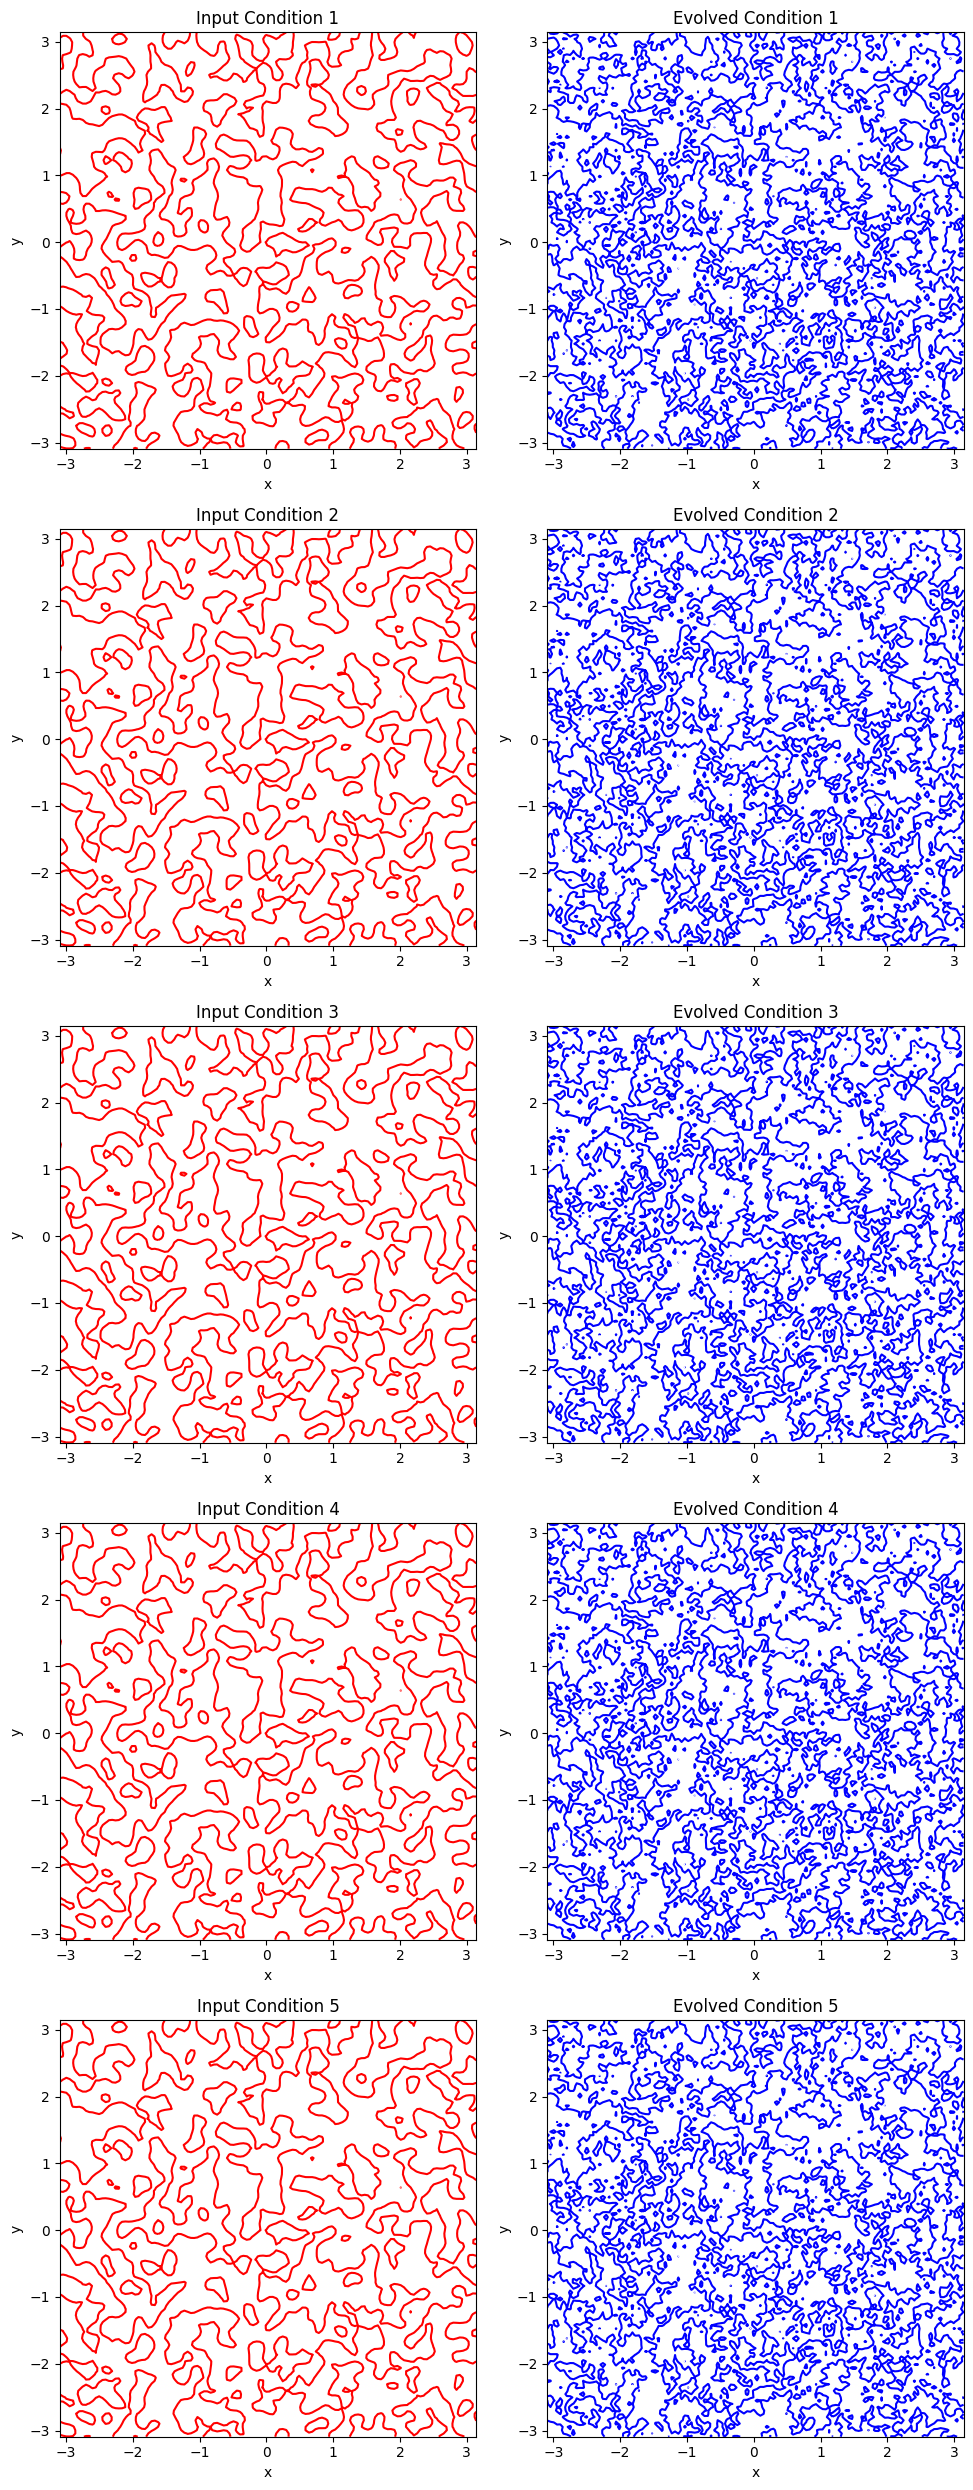

In [13]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

num_samples = 5  # Total number of test samples
fig, axs = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))  # Create a grid of subplots

for i in range(num_samples):
    plt_train = jnp.real(data_test[0][i])  # Extract sample i
    plt_train = plt_train[:, :, 0]  # Assuming last dimension holds channel info

    
    params = model.get_params(model.opt_state)
    model_prediction = model.operator_net(params, data_test[0][i])
    plt_pred = jnp.real(model_prediction)  # Extract prediction for sample i
    plt_pred = plt_pred[:, :, 0]

    # Plot input condition (Left column)
    axs[i, 0].contour(x, y, plt_train, levels=[0], colors="red")
    axs[i, 0].set_title(f'Input Condition {i+1}')
    axs[i, 0].set_aspect('equal', adjustable='box')
    axs[i, 0].set_xlabel('x')
    axs[i, 0].set_ylabel('y')

    # Plot evolved condition (Right column)
    axs[i, 1].contour(x, y, plt_pred, levels=[0], colors="blue")
    axs[i, 1].set_title(f'Evolved Condition {i+1}')
    axs[i, 1].set_aspect('equal', adjustable='box')
    axs[i, 1].set_xlabel('x')
    axs[i, 1].set_ylabel('y')

plt.tight_layout()
plt.show()


## this is for nothing need to check

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.example_libraries.stax import Dense, Gelu, serial
from jax.example_libraries.optimizers import optimizer, make_schedule
# from jax.scipy.fftpack import fftn, ifftn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from functools import partial
from jax.numpy.fft import fftn, ifftn, fftshift, ifftshift
from jax.example_libraries.optimizers import exponential_decay
import jax.numpy.fft as jfft
from jax.example_libraries.stax import Dense, Gelu, serial, glorot_normal
from spifol_archs import FNOBlock2D, Permute, complex_adam, MLP, modified_MLP




def fft2(x):
   """Applies a 2D FFT over the first two dimensions of the input array x."""
   return fftn(x, axes=(0, 1))


def ifft2(x):
   """Applies a 2D inverse FFT over the first two dimensions of the input array x."""
   return ifftn(x, axes=(0, 1))




# Define normalization and denormalization functions
def normalize(data):
   mean = jnp.mean(data)
   std = jnp.std(data)
   return (data - mean) / std, mean, std


def denormalize(data, mean, std):
   return data * std + mean



class SPiFOL:
   def __init__(self, L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers, mlp_layers,lr, arch):
       self.arch = arch
       self.N = N
       self.lr = lr
       # self.norm_par = norm_par
       self.eps = eps
       self.pp2 = pp2
       self.qq2 = qq2
       self.dt = dt
       self.L = L
       self.h = h
       self.x = x
       self.y = y
       # Initialize the network based on architecture type
       if arch == 'FNO':
           self.N_init, self.N_apply = serial(*fno_layers)
           _, params = self.N_init(random.PRNGKey(1234), (-1, N, N, 1))
          
       elif arch == 'MLP':
           self.N_init, self.N_apply = MLP(mlp_layers)
           params = self.N_init(random.PRNGKey(1234))
          
       elif arch == 'modified_MLP':
           self.N_init, self.N_apply = modified_MLP(mlp_layers)
           params = self.N_init(random.PRNGKey(1234))
       else:
           raise ValueError("Unsupported architecture!")


       self.params = params


    
       # Optimizer setup
       self.opt_init, self.opt_update, self.get_params = complex_adam(
           jax.example_libraries.optimizers.exponential_decay(
               lr, decay_steps=2000, decay_rate=0.9)
           )
      
       self.opt_state = self.opt_init(self.params)


       # Logging losses
       self.total_loss_log = []
       self.total_energy_loss_log = []


       # Initialize optimizer state
       self.opt_state = self.opt_init(self.params)
       self.itercount = iter(range(50000))


   @partial(jit, static_argnums=(0,))
   def operator_net(self, params, uk):
       if self.arch == 'FNO':
           uk = uk.reshape(-1, self.N, self.N, 1)  # Reshape input 
           O = self.N_apply(params, uk)  # Apply the FNO network
           O = jnp.real(O)  # Take the real part of the output
           O = O.reshape(-1,self.N, self.N)  # Reshape output
           return O
       elif self.arch == 'MLP':
           uk = uk.flatten()
           O = self.N_apply(params, uk)  # Directly apply the network
           O = O.reshape(self.N, self.N)  # Reshape output to match strain components
           # O = O / self.norm_par  # Normalize the output
           return O
       elif self.arch == 'modified_MLP':
           uk = uk.flatten()
           O = self.N_apply(params, uk)
           O = O.reshape(self.N, self.N)
           return O
       else:
           raise ValueError("Unsupported architecture type!")
      

   def allen_cahn_equation(self, uk, total_steps=2000):
        for _ in range(total_steps):
#             # cahn = eps**2
#             # uk = jnp.real(uk)

#             # # Expand self.pp2 and self.qq2 to support broadcasting
#             # self.pp2 = self.pp2[jnp.newaxis, ...]  # Shape: (1, 128, 128)
#             # self.qq2 = self.qq2[jnp.newaxis, ...]  # Shape: (1, 128, 128)
#             # # Allen-Cahn equation in Fourier space
#             # # s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk))
#             # # Allen-Cahn equation in Fourier space
#             # s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk))  # Broadcasting works here

#             # print("uk shape before anything:", uk.shape)
#             # print("self.pp2 shape before anything:", self.pp2.shape)
#             # print("self.qq2 shape before anything:", self.qq2.shape)
#             # print("cahn value:", cahn)


#             # # Compute denominator and ensure it matches uk's shape
#             # denominator = cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2))  # Shape: (1, 128, 128)
#             # denominator = jnp.broadcast_to(denominator, uk.shape)  # Match shape with uk

#             # # Compute v_hat and transform back
#         #     v_hat = s_hat / denominator  # Broadcasting works here
#         #     uk = jfft.ifft2(v_hat)
        
#         #     # v_hat = s_hat / (cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2)))
#         #     # uk = jfft.ifft2(v_hat)  # Update uk to the next state
#         # # uk = np.load('final_output.npy_20000.npy')
#         #     # print(f'shree is my heart')

#             # print("uk shape:", uk.shape)
#         #     print("self.pp2 shape:", self.pp2.shape)
#         #     print("self.qq2 shape:", self.qq2.shape)
#         #     print("denominator shape before broadcast:", (cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2))).shape)

#         #     print(cahn.shape, uk.shape, self.pp2.shape, self.qq2.shape)

            cahn = eps**2
            uk = jnp.real(uk)
            # uk = jnp.complex64(uk)

            # Ensure shapes match for broadcasting
            self.pp2 = self.pp2[..., jnp.newaxis]  # Shape: (128, 128, 1) --> (128, 128, 1, 1)
            self.qq2 = self.qq2[..., jnp.newaxis]  # Shape: (128, 128, 1) --> (128, 128, 1, 1)

            
            # Check the shapes of pp2 and qq2
            print(f"pp2 shape after reshaping: {self.pp2.shape}")  # Expected: (1, 128, 128, 1)
            print(f"qq2 shape after reshaping: {self.qq2.shape}")  # Expected: (1, 128, 128, 1)

            # Check uk shape before broadcasting
            print(f"uk shape before broadcasting: {uk.shape}")  # Expected: (20, 128, 128, 3)

            # Allen-Cahn equation in Fourier space
            denominator = cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2))  # Shape should be (1, 128, 128, 1)
            # denominator = denominator[..., jnp.newaxis]  # Ensure it's (1, 128, 128, 1)
            print(f"denominator shape before broadcasting: {denominator.shape}")  # Expected: (1, 128, 128, 1)

           # Broadcast denominator to uk's shape
            denominator = jnp.broadcast_to(denominator, uk.shape)  # Shape: (20, 128, 128, 3)
            print(f"denominator shape after broadcasting: {denominator.shape}")  # Expected: (20, 128, 128, 3)
            

            
            s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk))  # Shape: (20, 128, 128, 3)
            v_hat = s_hat / denominator  # Broadcasting works here
            uk = jfft.ifft2(v_hat)  # Shape: (20, 128, 128, 3)
            
            # Check if everything else is correct
            print(f"s_hat shape after broadcasting: {s_hat.shape}")  # Expected: (20, 128, 128, 3)
            print(f"v_hat shape after broadcasting: {v_hat.shape}")  # Expected: (20, 128, 128, 3)
            print(f"uk shape after computation: {uk.shape}")  # Expected: (20, 128, 128, 3)



        return jnp.real(uk)  # Return only the final state
   
   


#    @jax.jit
#    def allen_cahn_equation(self, uk, total_steps=2000):
        
         


#        # Reshape pp2 and qq2 once before the loop
#         pp2 = self.pp2[..., jnp.newaxis]  # Shape: (128, 128, 1)
#         qq2 = self.qq2[..., jnp.newaxis]  # Shape: (128, 128, 1)
        
#         for step in range(total_steps):
#             cahn = eps**2
#             uk = jnp.real(uk)
#             print(f'[{step}] uk before broadcasting: {uk.shape}')


#            # Print the shape of pp2 and qq2 before broadcasting
#             print(f'[{step}] pp2 before broadcast: {pp2.shape}')
#             print(f'[{step}] qq2 before broadcast: {qq2.shape}')

#            # If pp2 and qq2 are of shape (128, 128), broadcast them to (128, 128, 3) for alignment with uk
#             # self.pp2 = jnp.broadcast_to(self.pp2[..., jnp.newaxis], (self.pp2.shape[0], self.pp2.shape[1], uk.shape[3]))
#             # self.qq2 = jnp.broadcast_to(self.qq2[..., jnp.newaxis], (self.qq2.shape[0], self.qq2.shape[1], uk.shape[3]))

#             #  Broadcast pp2 and qq2 to match uk.shape[3]
#             pp2_broadcasted = jnp.broadcast_to(pp2, (pp2.shape[0], pp2.shape[1], uk.shape[3]))  # (128, 128, 3)
#             qq2_broadcasted = jnp.broadcast_to(qq2, (qq2.shape[0], qq2.shape[1], uk.shape[3]))  # (128, 128, 3)

        #    # Print the shape of pp2 and qq2 after broadcasting
        #     print(f'[{step}] pp2 after broadcast: {pp2_broadcasted.shape}')
        #     print(f'[{step}] qq2 after broadcast: {qq2_broadcasted.shape}')

        #     # Compute denominator
        #     denominator = cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2))  # Shape: (128, 128, 3)
        #     print(f'[{step}] denominator before broadcasting: {denominator.shape}')
            
        #     # # Broadcast denominator to match uk shape (20, 128, 128, 3)
        #     denominator = jnp.broadcast_to(denominator, uk.shape)  # Broadcast to (128, 128, 3)
        #     print(f'[{step}] denominator after broadcasting: {denominator.shape}')
            
        #     # Perform Fourier calculations
        #     s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk))
        #     v_hat = s_hat / denominator  # Element-wise division

        #     # Inverse FFT
        #     uk = jfft.ifft2(v_hat)
        #     print(f'[{step}] s_hat after broadcasting: {s_hat.shape}')
        #     print(f'[{step}] v_hat after broadcasting: {v_hat.shape}')
        #     print(f'[{step}] uk after broadcasting: {uk.shape}')
        # return jnp.real(uk)  # Return the real part



   @partial(jit, static_argnums=(0,))
   def loss_single(self, params, uk):
        u_nn = self.operator_net(params, uk) # predicted or next value of the initial condition
        u_nn = u_nn.reshape(-1, self.N, self.N)
        print(f'[uk ko shape : {uk.shape}')

        u_ac = self.allen_cahn_equation(uk)
        
        # Allen-Cahn equation loss
    #    energy_loss = self.total_energy(u_pred)
        datadriven_loss = jnp.mean((u_ac - u_nn) ** 2)
    #    total_loss = distance_loss + energy_loss
        return datadriven_loss
   

   @partial(jit, static_argnums=(0,))
   def step(self, i, opt_state, uk):
        params = self.get_params(opt_state)
        grads = grad(self.loss_single)(params, uk)
        return self.opt_update(i, grads, opt_state)


   def train(self, uk, nIter=1000):
        pbar = trange(nIter)
        for it in pbar:
            self.opt_state = self.step(next(self.itercount), self.opt_state, uk)
    #    self.itercount = iter(range(nIter))  # Create an iterator
            



            # Logger (log the loss every 100 iterations)
            if it % 100 == 0:
                params = self.get_params(self.opt_state)
                loss = self.loss_single(params, uk)
                self.total_loss_log.append(loss)
                # self.total_energy_loss_log.append(energy_loss)
                pbar.set_postfix({'Loss': loss})


# Parameters
N = 128 # no. of grid points
eps = 0.05 # epsillon 
lr = 0.1 # learning rate
dt = 0.0001 # time step or time increment
L = 2 * jnp.pi # length of domian
h = L/N # spacing between grid or length of grid





x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)


theta = jnp.arctan2(y, x)
# Generate input condition
xx, yy = jnp.meshgrid(x, y)
# input_condition = jnp.tanh((2 - jnp.sqrt(xx**2 + yy**2)) / jnp.sqrt(2)* eps)
# input_condition = np.load (os.path.join(save_dir, "u_train.npy"), np.array(data.u_train))
# Load the .npy file
input_condition = np.load('data_generation/u_test.npy')
input_condition = input_condition[:1]

# Inspect the data
# print(input_condition)
# print(type(input_condition))


 # defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2 , 0)])




# # square of wavenumber in x and y direction
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction


# # creating meshgrid in x and y direction for square of wavenumber
pp2, qq2 = jnp.meshgrid(p2, q2)



# arch_list = ['FNO', 'MLP', 'modified_MLP']
arch_list = ['FNO']
# arch = 'modified_MLP'
# mlp layers
mlp_layers = [16384, 32, 32, 16384]


# Define FNO layers
fno_layers = [
   Dense(32),
#    Permute("ijkl->iljk"),
#    FNOBlock2D(32),
   Gelu,  # activation can be changed here
#    FNOBlock2D(32),
#    Gelu,
#    FNOBlock2D(32),
#    Permute("ijkl->iklj"),
   Dense(32),
   Gelu,
   Dense(1),
]



cahn = eps**2
for arch in arch_list:
   # Initialize and train the model
    model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers,mlp_layers,lr, arch)
    final_state = model.allen_cahn_equation(input_condition)
    # model.train(input_condition, nIter=1000)


# params = model.get_params(model.opt_state)
# model_prediction = model.operator_net(params, input_condition).reshape(N, N)



# Plot the initial and final states
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Input condition plot
axs[0].contour(x, y, jnp.real(input_condition.T), levels=[0], colors="black")
axs[0].contour(x, y, jnp.real(final_state.T), levels=[0], colors="red")

axs[0].set_title('Input Condition and Evolved conditiona after 2000 time step')
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')


# #    # Plot loss
axs[1].plot(model.total_loss_log)
axs[1].set_title('Training Loss')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Loss')






plt.tight_layout()
plt.show()

            

pp2 shape after reshaping: (128, 128, 1)
qq2 shape after reshaping: (128, 128, 1)
uk shape before broadcasting: (1, 128, 128, 3)
denominator shape before broadcasting: (128, 128, 1)
denominator shape after broadcasting: (1, 128, 128, 3)
s_hat shape after broadcasting: (1, 128, 128, 3)
v_hat shape after broadcasting: (1, 128, 128, 3)
uk shape after computation: (1, 128, 128, 3)
pp2 shape after reshaping: (128, 128, 1, 1)
qq2 shape after reshaping: (128, 128, 1, 1)
uk shape before broadcasting: (1, 128, 128, 3)
denominator shape before broadcasting: (128, 128, 1, 1)


ValueError: Incompatible shapes for broadcasting: (128, 128, 1, 1) and requested shape (1, 128, 128, 3)

## debugging data generation because all data are the same before but from this cell will be different
## this cell code is correct for data generation, it should be given different data 

Saving training data to u_train.npy...
Saving grid points to grid.npy...
Saving grid points to grid.npy...
Time to save the data: 0.02 seconds
Data saving completed!


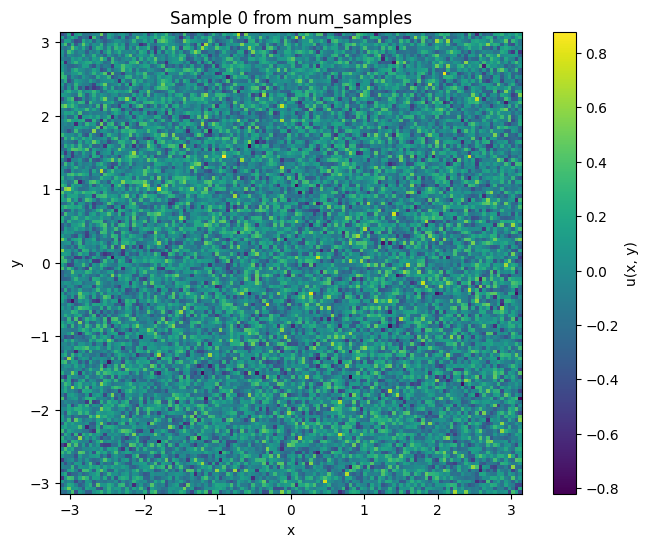

In [ ]:
import jax.numpy as jnp
import numpy as np
from jax import random
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import os
import time





# Exponential quadratic kernel (Gaussian kernel)
def exp_quadratic(X1, X2, length_scale):
    """Compute the exponential quadratic kernel."""
    dists = cdist(X1, X2, metric="sqeuclidean") #dists is distance and cdists is computed distance between two points 
    # print("Distances min:", jnp.min(dists), "max:", jnp.max(dists))
    kernel = jnp.exp(-dists / (2 * length_scale**2))
    # print("Kernel min:", jnp.min(kernel), "max:", jnp.max(kernel))
    return kernel


# Gaussian process data generator
def gaussian_process_2d(x, n_grid, n_samples, length_scale_list, u_mean=0.0, key=None):
    """
    Generate 2D Gaussian process samples.
    
    Args:
        x: Tuple of domain limits [x1, x2, y1, y2].
        n_grid: Number of grid points in each dimension.
        n_samples: Number of samples to generate.
        length_scale_list: List of length scales for kernel.
        u_mean: Mean value for Gaussian process.
        key: PRNGKey for randomization.

    Returns:
        X: Grid points.
        ys: Samples generated from the Gaussian process.
    """
    x1, x2, y1, y2 = x
    # Create grid
    xx, yy = jnp.meshgrid(
        jnp.linspace(x1, x2, n_grid), jnp.linspace(y1, y2, n_grid)
    )
    grid_points = jnp.stack([xx.ravel(), yy.ravel()], axis=-1)

    if key is None:
        key = random.PRNGKey(42)

    samples = []
    for i in range(n_samples):
        # print(f'for sample {i+1}')
        # Select random length scale
        key, subkey = random.split(key)  # Split the key to ensure randomness
        length_scale = random.choice(subkey, jnp.array(length_scale_list))
        # Compute covariance matrix
        cov = exp_quadratic(grid_points, grid_points, length_scale)
        jitter = 1e-5
        cov += jitter * jnp.eye(cov.shape[0])

        # print("Covariance matrix shape:", cov.shape)
        # eigenvalues = jnp.linalg.eigvalsh(cov)
        # # print("After adding jitter:")
        # print("Covariance matrix eigenvalues min:", jnp.min(eigenvalues), "max:", jnp.max(eigenvalues))

        # Generate sample
        sample = random.multivariate_normal(key, u_mean * jnp.ones(grid_points.shape[0]), cov)
        samples.append(sample)

    return grid_points, jnp.array(samples)


# # Normalize function
# def normalize(data):
#     """Normalize data to the range [-1, 1]."""
#     return 2 * (data - jnp.min(data)) / (jnp.max(data) - jnp.min(data)) - 1


def normalize(data):
    """Normalize data to the range [-1, 1]."""
    min_val = jnp.min(data)
    max_val = jnp.max(data)
    if max_val - min_val == 0:
        return data  # Return unchanged if normalization isn't possible
    return 2 * (data - min_val) / (max_val - min_val) - 1


# Data class
class Data:
    def __init__(self, x, n_grid, length_scale_list, num_samples):
        """
        Initialize data generator.

        Args:
            x: Tuple of domain limits [x1, x2, y1, y2].
            n_grid: Resolution of the grid (number of grid points per dimension).
            length_scale_list: List of length scales for the Gaussian process.
            train_num: Number of training samples to generate.
            test_num: Number of testing samples to generate.
        """
        self.x = x
        self.n_grid = n_grid
        self.length_scale_list = length_scale_list
        self.num_samples = num_samples
        # self.test_num = test_num
        self.__init_data()

    def __init_data(self):
        """Initialize training and testing data."""
        self.X, self.num_samples = self.u_data(self.num_samples)
        # _, self.u_test = self.u_data(self.test_num)

    def u_data(self, n_samples=1):
        """
        Generate Gaussian process data.

        Args:
            n_samples: Number of samples to generate.

        Returns:
            X: Grid points.
            us: Corresponding u(x) values at the grid points.
            us: Corresponding u(x) values at the grid points with 3 channels (RGB).
        """
        # Generate data using Gaussian process
        X, us = gaussian_process_2d(
            self.x, self.n_grid, n_samples, self.length_scale_list
        )

        


        # Normalize and reshape the samples
        us = us - jnp.mean(us, axis=0)  # Subtract mean to introduce variance

        us = normalize(us)
        us = us.reshape(-1, self.n_grid, self.n_grid, 1)

        # print(f"Generated {n_samples} samples with shape: {us.shape}")


        # Now create RGB data for each sample, using np.random.rand for each channel
        # Here we create random RGB values for each sample (you can adjust this as needed)
        us_rgb = np.random.rand(n_samples, self.n_grid, self.n_grid, 3)  # RGB values for color images

        key = random.PRNGKey(42)  # Initialize PRNG key
        key, subkey = random.split(key)  # Split key to create subkey


        # You could also modify the us data to contain meaningful RGB values
            # Example: combining some part of 'us' for each channel
        us_rgb[..., 0] = normalize(random.normal(subkey, shape=us[..., 0].shape))  # Red
        us_rgb[..., 1] = normalize(random.normal(subkey, shape=us[..., 0].shape))  # Green
        us_rgb[..., 2] = normalize(random.normal(subkey, shape=us[..., 0].shape))  # Blue


        return X, us_rgb

        # return X, us


# Example Usage
if __name__ == "__main__":
    # Example: Adjust resolution and domain length
    domain = (-jnp.pi, jnp.pi, -jnp.pi, jnp.pi)  
    resolution = 128  # Number of grid points per dimension
    length_scale_list = [0.1, 0.5, 1.0, 2.0]  # Kernel length scales # its indicate the smoothness of the data 
    num_samples = 5 # Number of training samples
    # test_samples = 5  # Number of testing samples

    # Create data object
    data = Data(domain, resolution, length_scale_list, num_samples)

    # Specify the directory where y want to save the data
    save_dir = './data_generation_checking/'

     # Ensure the directory exists, create it if not
    os.makedirs(save_dir, exist_ok=True)

    # Access generated data
    # print("Training data shape (u_train):", data.u_train.shape)  # (train_samples, resolution, resolution, 1)
    # print("Testing data shape (u_test):", data.u_test.shape)  # (test_samples, resolution, resolution, 1)

    # Start the timer
    start_time = time.time()

    # Save the training and testing data
    print("Saving training data to u_train.npy...")
    np.save(os.path.join(save_dir, "phasefield_data.npy"), np.array(data.num_samples))

    # print("Saving testing data to u_test.npy...")
    # np.save(os.path.join(save_dir, "u_test.npy"), np.array(data.u_test))

    print("Saving grid points to grid.npy...")
    np.save(os.path.join(save_dir, "grid.npy"), np.array(data.x))

    # print("Data saving completed!")

    # # Save the grid points (optional, if you want to reconstruct spatial locations)
    print("Saving grid points to grid.npy...")
    np.save("grid.npy", np.array(data.X))  # Assuming 'data.X' contains the grid points

    # Calculate the elapsed time
    elapsed_time = time.time() - start_time
    print(f"Time to save the data: {elapsed_time:.2f} seconds")

    print("Data saving completed!")




    # # Specify the directory where you want to save the data
    # save_dir = './data_generation/'

    # # Ensure the directory exists, create it if not
    # os.makedirs(save_dir, exist_ok=True)

    # # Save the data with the full path to the specific folder
    # np.save(os.path.join(save_dir, "u_train_dg.npy"), np.array(data.u_train))
    # np.save(os.path.join(save_dir, "u_test_dg.npy"), np.array(data.u_test))



# # Save the training and testing data
# np.save("u_train_dg.npy", np.array(data.u_train))
# np.save("u_test_dg.npy", np.array(data.u_test))

# # # Save the grid points (optional, if you want to reconstruct spatial locations)
# np.save("grid.npy", np.array(data.X))  # Assuming 'data.X' contains the grid points


# Select a sample to plot
sample_index = 0  # Choose a specific sample (e.g., the first one)
sample = data.num_samples[sample_index, :, :, 0]  # Extract the 2D array for the sample
# print(f'sample data = {sample}')

# Plot the sample
plt.figure(figsize=(8, 6))
plt.imshow(sample, extent=[-jnp.pi, jnp.pi, -jnp.pi, jnp.pi], origin='lower', cmap='viridis')
plt.colorbar(label="u(x, y)")
plt.title(f"Sample {sample_index} from num_samples")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


## this cell again for checking the all data are different or same 

In [3]:
import numpy as np

train_data = np.load("./data_generation_checking/phasefield_data.npy")
print(f"Training data shape: {train_data.shape}")

# Check if all images are identical
if np.all(train_data == train_data[0]):
    print("All training samples are identical!")
else:
    print("Training samples are different.")


Training data shape: (4000, 128, 128, 3)
Training samples are different.


## This plot for checking all the saving data are different or not

plt_train shape: (128, 128)
plt_train shape: (128, 128)
plt_train shape: (128, 128)
plt_train shape: (128, 128)
plt_train shape: (128, 128)


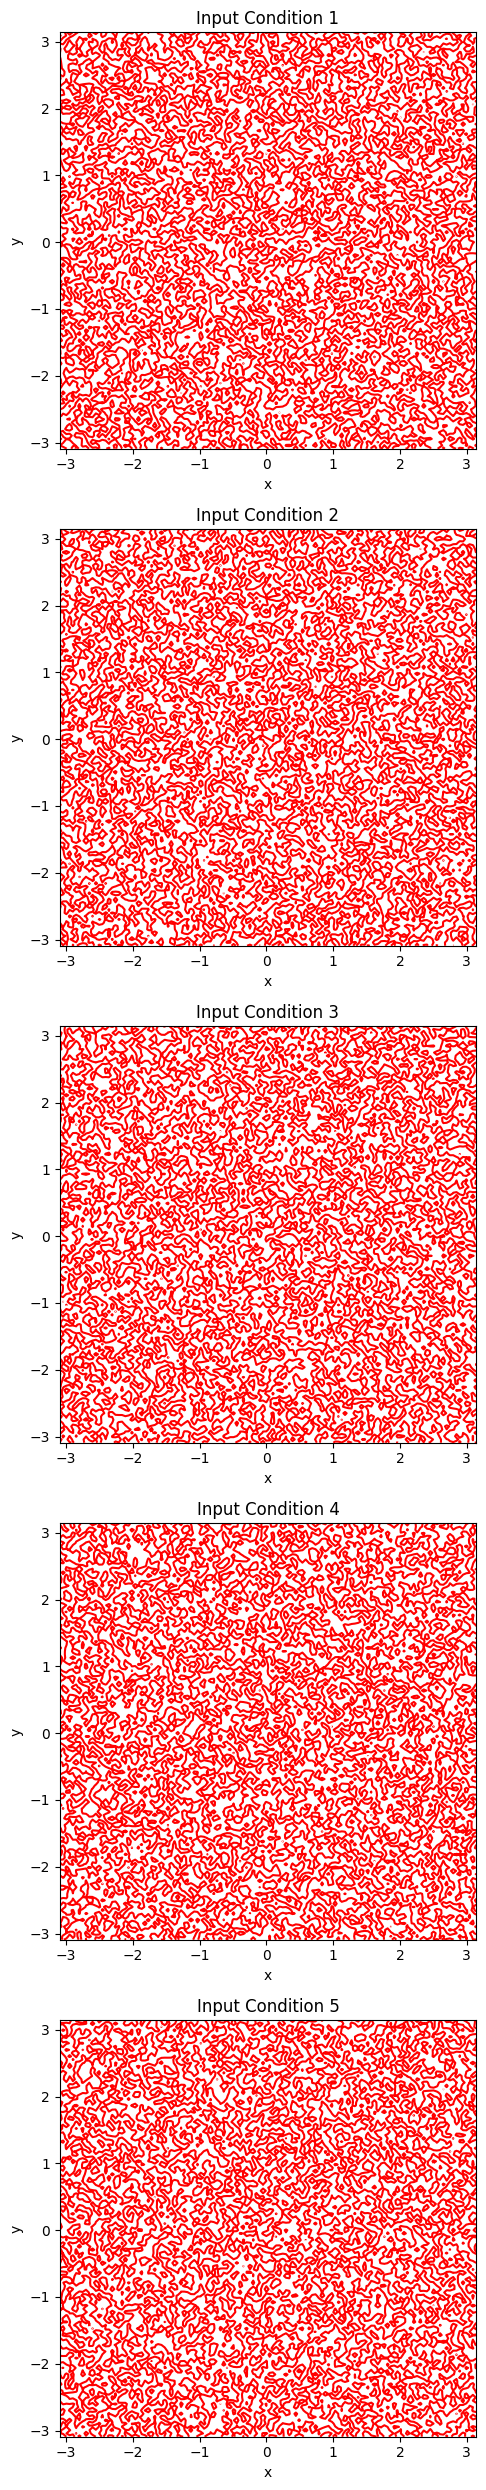

In [4]:
import matplotlib.pyplot as plt
import jax.numpy as jnp# Parameters
N = 128 # no. of grid points
eps = 0.05 # epsillon 
lr = 0.1 # learning rate
dt = 0.0001 # time step or time increment
L = 2 * jnp.pi # length of domian
h = L/N # spacing between grid or length of grid





x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)



num_samples = 5  # Total number of test samples
fig, axs = plt.subplots(num_samples, 1, figsize=(10, 5 * num_samples))  # Create a grid of subplots

for i in range(num_samples):
    plt_train = jnp.real(train_data[i])  # Extract sample i
    plt_train = plt_train[:, :, 0]  # Assuming last dimension holds channel info
    print(f'plt_train shape: {plt_train.shape}')

    
    # params = model.get_params(model.opt_state)
    # model_prediction = model.operator_net(params, data_test[0][i])
    # plt_pred = jnp.real(model_prediction)  # Extract prediction for sample i
    # plt_pred = plt_pred[:, :, 0]

    # Plot input condition (Left column)
    axs[i].contour(x, y, plt_train, levels=[0], colors="red")
    axs[i].set_title(f'Input Condition {i+1}')
    axs[i].set_aspect('equal', adjustable='box')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')

    # # Plot evolved condition (Right column)
    # axs[i, 1].contour(x, y, plt_pred, levels=[0], colors="blue")
    # axs[i, 1].set_title(f'Evolved Condition {i+1}')
    # axs[i, 1].set_aspect('equal', adjustable='box')
    # axs[i, 1].set_xlabel('x')
    # axs[i, 1].set_ylabel('y')

plt.tight_layout()
plt.show()
